----------
----------


<left>
    <img src="https://itsrapid.io/wp-content/uploads/2022/07/Instacart-Logo-NEw-Trans.png" width='50%'> 
</left>

----------
<h1 align="center"> Instacart Market Basket Analysis and Prediction</h1>
<br>
<center align="left"> <font size='4'>  Portfolio Project </font>
</center>
<center align="left"> <font size='4'>  Maria Opekhtina, April 2023 </font>
</center>
<br>

----------

# Project Introduction

## Project Objective 

Use data on Instacart customer orders over time to predict which previously purchased products will be in a user’s next order.

From Instacart:
"The applications:
    We hope the machine learning community will use this data to test models for predicting products that a user will buy again, try for the first time or add to cart next during a session."

## About Instacart 

Instacart is an American delivery company that operates a grocery delivery and pick-up service in the United States and Canada. The company offers its services via a website and mobile app. The service allows customers to order groceries from participating retailers with the shopping being done by a personal shopper. 



## Dataset
The dataset for this project is a relational set of files describing customers' orders over time. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, there are between 4 and 100 orders, with the sequence of products purchased in each order. The dataset also includes the week and hour of day the order was placed, and a relative measure of time between orders. 

There are 6 tables in this dataset:

- orders.csv 
    - contains data about orders

- order_products_train.csv 
    - last order details (recommended training set)
- order_product_prior.csv 
    - prior orders details (data from user's previous orders)

- products.csv 
    - product details

- aisles.csv 
    - aisle details

- departments.csv  
    - department details

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 4/05/2023


- For this project, we will be using the order_products_train dataset combined with orders as both our training and testing data.

- Order_product_prior datatable will be combined with the description tables (products, aisles and departments) as well as orders table to create features for our analysis.
- We will also be conducting EDA on the users prior orders to see user preferences on historical data
- The dataset is quite large and to be able to analyze it, I implemented a memory-saving function, which saved me about 50% of space 


# Imports 

In [467]:
import pandas as pd
import numpy as np
import re


# visualiation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import plotly.express as px

# NLP
from sklearn.feature_extraction.text import CountVectorizer

# modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline

# model interpretablity
import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer
#import shap

# algos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import TargetEncoder, CountEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin #inheritance class for custom transformers

# metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, roc_curve


# Functions used in this notebook

In [25]:
def reduce_memory(df):
    """
    This function reduces the memory usage of a dataframe by downcasting its integer and floating point columns.
    
    """
    start_mem_usg = df.memory_usage(deep=True).sum() / 1024**2 
    print("Memory usage of dataframe is: {:.2f} MB".format(start_mem_usg))
    
    # Iterate over all columns in the dataframe
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    mem_usg = df.memory_usage(deep=True).sum() / 1024**2
    print("Memory usage after optimization: {:.2f} MB".format(mem_usg))
    print("Reduced by {:.1f}%.".format(100 * (start_mem_usg - mem_usg) / start_mem_usg))

    return df

In [ ]:
def baseline(X, y, random_state):
    
    """
    Fits X and y to models below and returns cross-val scores for f1
    
    """
    
    models = [LogisticRegression(max_iter=10000, random_state = random_state),
             DecisionTreeClassifier(random_state = random_state),
             XGBClassifier(random_state = random_state),
             lgb.LGBMClassifier(random_state = random_state)]
    
    f1_scores = {}
    
    for model in models:
        
        scores = cross_val_score(model, X, y, cv=5, scoring='f1')
        
        f1_scores[model]=scores.mean()
    return f1_scores  

In [ ]:
def reports(y_pred, y_test):

    """
    Display calssification report and confusion matrix
    """

    matrix = confusion_matrix(y_pred, y_test)
    sns.heatmap(matrix, cmap='Purples', annot = True, fmt="g")
    plt.show()
    print(classification_report(y_pred, y_test))

In [609]:
def roc_auc(y_train, y_test):
    
    """
    Display ROC AUC plot
    
    """
    model_roc_auc = roc_auc_score(y_train, y_test) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_train, y_test)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='orange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='x', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.show()

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    
    """
    Calculates F1 score for the Keras model
    
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [630]:
def frequency_encode_columns(df, columns_to_encode):
    """
    Frequency Encodes selected columns
    
    """
    for col in columns_to_encode:
        df[col] = df[col].replace(df[col].value_counts(normalize=True))
        df[col] = df[col].astype('int8')

    return df

# Data 

## Load Data

In [3]:
orders = pd.read_csv('orders.csv')
train_set = pd.read_csv('order_products__train.csv')
prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

## Quick review of loaded tables
- Checking size of each table to see if there is any shrinkage when merging
- Will be helpful in discerning how these tables should be merged


### Orders
- Includes order information for each user in the dataset

In [4]:
orders.shape

(3421083, 7)

In [5]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

### Training Set
- data that will be used to build our training and testing dataframe

In [6]:
train_set.shape

(1384617, 4)

In [7]:
train_set.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

### Prior Orders

- Will be used to aggregate prior orders data in combination with the descriptor tables

    

In [8]:
prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [9]:
prior.shape

(32434489, 4)

### Products
- contains data about products in our dataset

In [10]:
products.shape

(49688, 4)

In [11]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

### Aisles
- contains aisle names 

In [12]:
aisles.shape

(134, 2)

In [13]:
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

### Departments
- contains department names

In [14]:
departments.shape

(21, 2)

In [15]:
departments.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

## Data Wrangling
Prior orders data table is a great source of information pertaining to the user history for users in the training set. There are several steps that will need to take place in order for us to use that infomation effectively:

Steps:
1. Join training set with orders to eliminate users that will not be analyzed during this project
2. Create a list of said users and apply them as a filter on orders table
3. Join filtered orders table with prior order table to create our training set
4. Merge our prior orders table with descriptor tables


### Joining training set with orders
- to attach user_id to train set 
- add user_id's from our new table to a list to be used as a filter
- apply filter to orders table

In [16]:
train_orders = train_set.merge(orders, on='order_id', how='left')

In [17]:
train_users = train_orders['user_id'].unique()

In [18]:
train_orders.shape

(1384617, 10)

### Filtering orders table only keeping users from train set

In [19]:
train_user_orders = orders[orders['user_id'].isin(train_users)]

In [20]:
train_user_orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

### Merging filtered orders table with prior orders table
- this will only leave users that are in the train set

In [21]:
prior_orders = train_user_orders.merge(prior, on='order_id', how='left')

In [22]:
prior_orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  
0                     NaN       196.0                1.0        0.0  
1                     NaN     14084.0                2.0        0.0  
2                     NaN     12427.0                3.0        0.0  
3                     NaN     26088.0                4.0        0.0  
4                     NaN     26405.0                5.0        0.0

In [23]:
prior_orders.shape

(20773200, 10)

### Removing train rows from prior table

In [24]:
prior_orders = prior_orders[prior_orders['eval_set']=='prior']

In [25]:
prior_orders.shape

(20641991, 10)

### Merging Prior orders table with product, aisle, department tables

In [26]:
prior_orders = prior_orders.merge(products, on='product_id', how='left')\
                           .merge(aisles, on='aisle_id', how='left')\
                           .merge(departments, on='department_id', how='left')

In [27]:
prior_orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN       196.0                1.0        0.0   
1                     NaN     14084.0                2.0        0.0   
2                     NaN     12427.0                3.0        0.0   
3                     NaN     26088.0                4.0        0.0   
4                     NaN     26405.0                5.0        0.0   

                              product_name  aisle_id  department_id  \
0                                     Soda        77              7   
1  Organic Unsweetened Vanilla Almond Milk        91             16   
2                      Original Beef Jerky        23             19   
3               Aged White Cheddar Popcorn        23             19   
4         XL Pick-A-Size Paper Towel Rolls        54             17   

             aisle  department  
0      soft drinks   beverages  
1  soy lactosefree  dairy eggs  
2    popcorn jerky      snacks  
3    popcorn jerky      snacks  
4      paper goods   household

In [28]:
prior_orders.shape

(20641991, 15)

In [29]:
# Reducing memory usage
prior_orders = reduce_memory(prior_orders)

Memory usage of properties dataframe is : 2519.7742919921875  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1220.5156726837158  MB
This is  48.4375 % of the initial size


### Saving dataframes to csv 

In [31]:
prior_orders.to_csv('prior_orders.csv', index=False)
train_orders.to_csv('train_orders.csv', index=False)

### Order tables to free up space

In [32]:
del prior
del orders

# EDA of prior table
In this section we are going to take a look at our pior orders table and see if can find any interesting insights using visualization.

The dataset is failry large: 20641991 rows and 15 columns, so we run the memory_saving function

- We are going to be checking:
    - Product, Aisle, Depratment reorders
    - User shopping preferences for days and hours of day
    - User shopping habits (basket size)
    - Product counts by aisle and department

In [612]:
df = pd.read_csv('prior_orders.csv')

In [34]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 2362.2885208129883  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1063.0299015045166  MB
This is  45.00000284210296 % of the initial size


In [35]:
df.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN       196.0                1.0        0.0   
1                     NaN     14080.0                2.0        0.0   
2                     NaN     12424.0                3.0        0.0   
3                     NaN     26080.0                4.0        0.0   
4                     NaN     26400.0                5.0        0.0   

                              product_name  aisle_id  department_id  \
0                                     Soda        77              7   
1  Organic Unsweetened Vanilla Almond Milk        91             16   
2                      Original Beef Jerky        23             19   
3               Aged White Cheddar Popcorn        23             19   
4         XL Pick-A-Size Paper Towel Rolls        54             17   

             aisle  department  
0      soft drinks   beverages  
1  soy lactosefree  dairy eggs  
2    popcorn jerky      snacks  
3    popcorn jerky      snacks  
4      paper goods   household

## Quick look at the dataset

### Attributes
 1. <b>order_id </b>- unique id assigned to each order in the table                 
 2. <b>user_id</b> - unique user id      
 3. <b>eval_set</b> - can be test, train or prior (this table only has prior) 
 3. <b>order_number</b> - sequential order number for each customer         
 4. <b>order_dow </b>- day of the week on which the order was placed    
 5. <b>order_hour_of_day</b> -  hour of day on which the order was placed                   
 6. <b>days_since_prior_order </b> - time difference between current and previous order in days                  
 7. <b>product_id</b>- unique product id            
 8. <b>add_to_cart_order</b> - product quantity per order             
 9. <b>reordered</b> - idicates if product was a reorder or a first time purchase                        
 10.<b>product_name</b> - product description            
 11. <b>aisle_id</b>   - unique aisle id               
 12. <b>department_id</b>     - unique department id           
 13. <b>aisle</b> - aisle description                       
 14. <b>department</b>  - department description


### Datatypes


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641991 entries, 0 to 20641990
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   user_id                 int32  
 2   eval_set                object 
 3   order_number            int8   
 4   order_dow               int8   
 5   order_hour_of_day       int8   
 6   days_since_prior_order  float16
 7   product_id              float16
 8   add_to_cart_order       float16
 9   reordered               float16
 10  product_name            object 
 11  aisle_id                int16  
 12  department_id           int8   
 13  aisle                   object 
 14  department              object 
dtypes: float16(4), int16(1), int32(2), int8(4), object(4)
memory usage: 1.0+ GB


In [37]:
columns = ['order_id', 'product_id', 'user_id', 'order_dow', 'order_hour_of_day',       
           'aisle_id', 'department_id']

In [38]:
df[columns]=df[columns].astype('object')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641991 entries, 0 to 20641990
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                object 
 1   user_id                 object 
 2   eval_set                object 
 3   order_number            int8   
 4   order_dow               object 
 5   order_hour_of_day       object 
 6   days_since_prior_order  float16
 7   product_id              object 
 8   add_to_cart_order       float16
 9   reordered               float16
 10  product_name            object 
 11  aisle_id                object 
 12  department_id           object 
 13  aisle                   object 
 14  department              object 
dtypes: float16(3), int8(1), object(11)
memory usage: 1.8+ GB


### Checking for null values

- days_since_prior_order has missing values
    - indicates 1st order by a customer
    - this will be imputed with 0
    
   

In [40]:
df.isnull().sum()

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    1322352
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [41]:
df = df.fillna(0)

## Reorders Analysis

We are going to take a look at the 'reordered' column and check it's relationship with other columns

### Reordered vs Not reordered

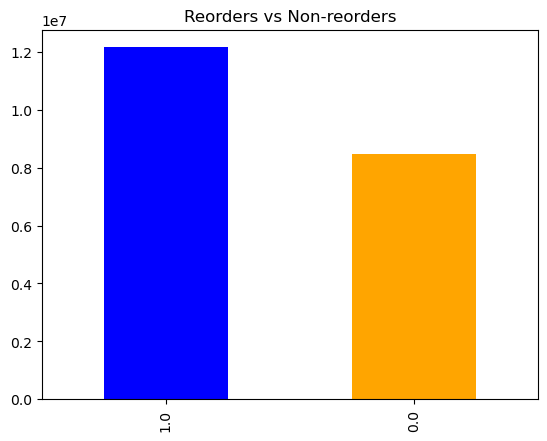

In [43]:
df['reordered'].value_counts().plot(kind='bar', title='Reorders vs Non-reorders', color=['b','orange']);

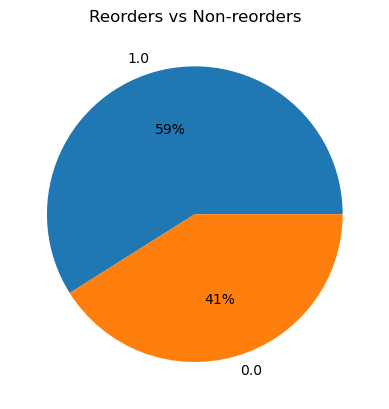

In [44]:
df['reordered'].value_counts(normalize=True).plot(kind='pie', title='Reorders vs Non-reorders', autopct='%.0f%%')
pylab.ylabel('');

### Reorders by Product

#### Most reordered product

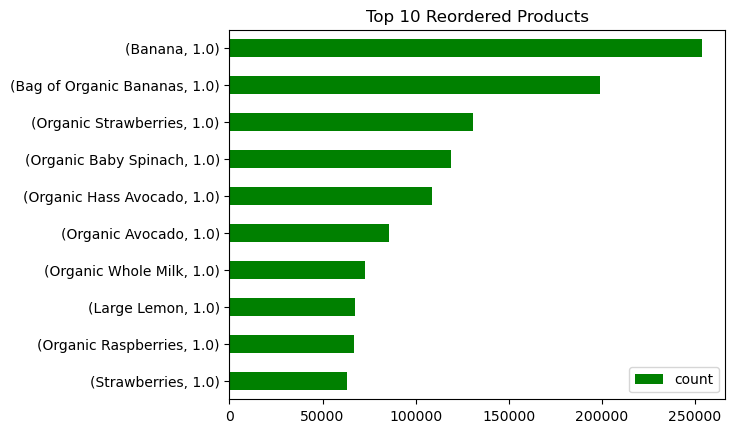

In [45]:
reordered_product = df[df['reordered']==1]

reordered_product = pd.DataFrame(reordered_product.groupby('product_name')['reordered']\
                                                  .value_counts())\
                                                  .rename(columns={'reordered':'count'})    

reordered_product.sort_values(by='count', ascending=False)\
                 .head(10)\
                 .plot(kind='barh', title='Top 10 Reordered Products', color='g')\
        
pylab.ylabel('')
plt.gca().invert_yaxis();

#### Least reordered product

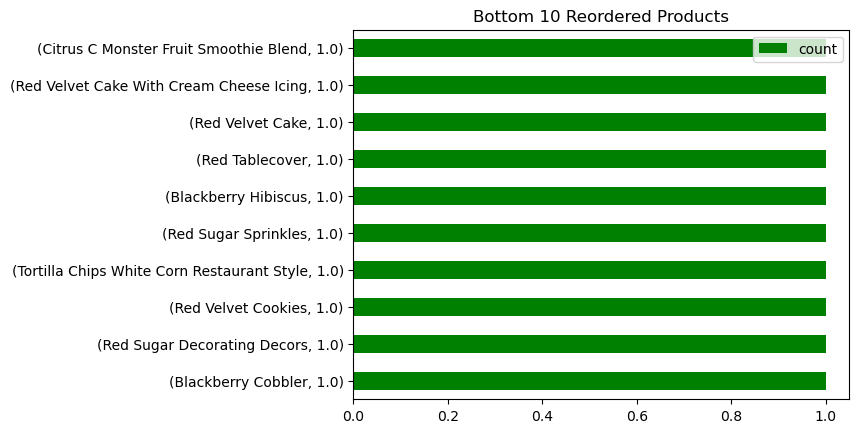

In [46]:
reordered_product = df[df['reordered']==1]

reordered_product = pd.DataFrame(reordered_product.groupby('product_name')['reordered']\
                                                  .value_counts())\
                                                  .rename(columns={'reordered':'count'})    

reordered_product.sort_values(by='count')\
                 .head(10)\
                 .plot(kind='barh', title='Bottom 10 Reordered Products', color='g')\
        
pylab.ylabel('')
plt.gca().invert_yaxis();

### Reorder Analysis by total product orders


In [47]:
# getting value count for each product 
prod_count = pd.DataFrame(df['product_name'].value_counts()).rename(columns={'product_name':'count'})
# getting reorder count by product
prod_reord = df.groupby('product_name')['reordered'].value_counts().unstack()
# merging 2 tables above together to plot
prod_cnt_reord = prod_count.merge(prod_reord, left_index=True, right_index=True)

#### Top ordered products vs reorders
- the same top 10 as in the most reordered product, with some values swapping places
- looks like majority of purcahses of these items have been reorders

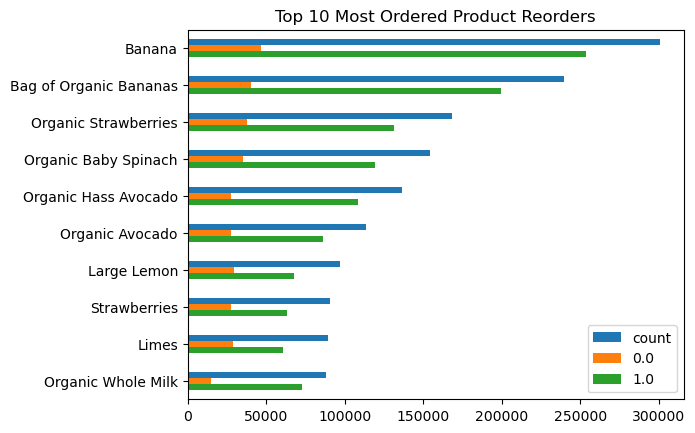

In [48]:
prod_cnt_reord.head(10).plot(kind='barh', title='Top 10 Most Ordered Product Reorders')
pylab.ylabel('')
plt.gca().invert_yaxis();

#### Bottom 10 items by reorder 
- items are completely different from the bottom 10 from above
- most of the times, these items have only ordered less than 5 times with 1-2 reorders
- organic nutmeg seem to be the only outlier

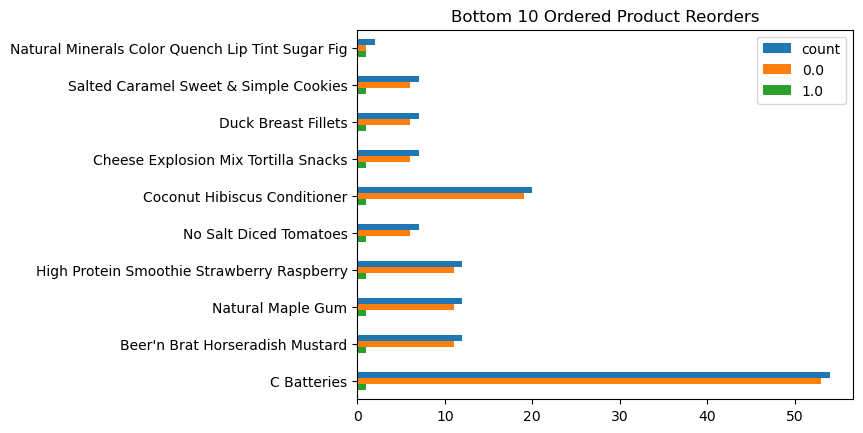

In [49]:
prod_cnt_reord.sort_values(by=1).head(10).plot(kind='barh', title='Bottom 10 Ordered Product Reorders')
pylab.ylabel('')
plt.gca().invert_yaxis();

### Reorders by department
- Order count and reorder count seem to be in lilne for most departments
- Snacks has more orders but less reorders than beverages

In [50]:
dept_count = pd.DataFrame(df['department'].value_counts()).rename(columns={'department':'count'})
dept_reord = df.groupby('department')['reordered'].value_counts().unstack()
dept_cnt_reord = dept_count.merge(dept_reord, left_index=True, right_index=True)

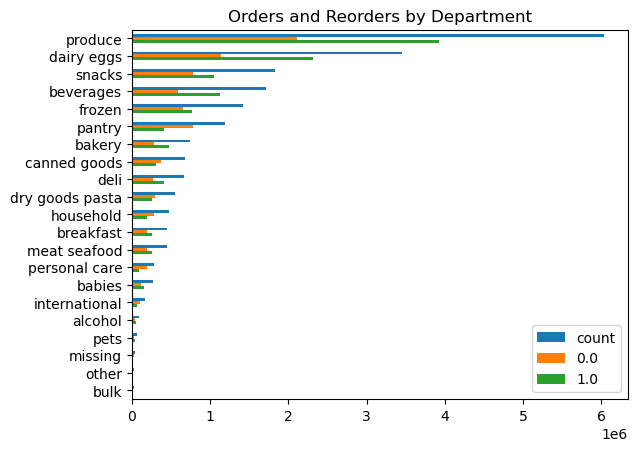

In [51]:
dept_cnt_reord.plot(kind='barh', title='Orders and Reorders by Department')
pylab.ylabel('')
plt.gca().invert_yaxis()
plt.legend(loc='lower right');

### Reorder by aisle - top 10
- fruits and vegetables are top 3

In [52]:
aisle_count = pd.DataFrame(df['aisle'].value_counts()).rename(columns={'aisle':'count'})
aisle_reord = df.groupby('aisle')['reordered'].value_counts().unstack()
aisle_cnt_reord = aisle_count.merge(aisle_reord, left_index=True, right_index=True)

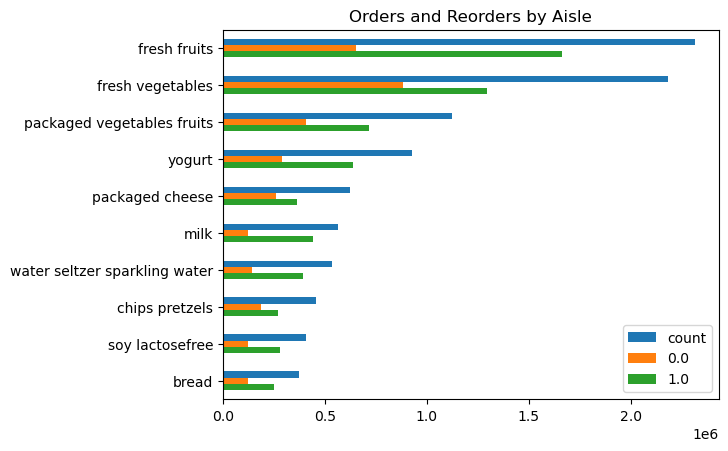

In [53]:
aisle_cnt_reord.head(10).plot(kind='barh', title='Orders and Reorders by Aisle')
pylab.ylabel('')
plt.gca().invert_yaxis()
plt.legend(loc='lower right');

### Reorder analysis findings:

- Almost 60% of the products ordered have been reordered items, while 40% were first time purchases
- 60% of our top 10 most reordered items have are 'Organic'
- 90% of top 10 most reordered items are fruits and vegetables
- Interestingly, 60% of least reordered items had the word 'Red' in them
- 3 of those were velvelt cakes
- Often reordered products are essentials, snacks and alcohol seem to be ordered less
- When looking at most ordered product and their reorder ratios, they seem to align with top 10 most reordered product
- No one like C Batteries enough to reorder
- Reorder by Aisle and department seem to align nicely with total times bought from them

## User Shopping Preferences: Day of Week and Hour of Day
- Dataset had input for days of week in 0-6 format, without indication which system was used
- For this project, we are going to assume pandas dayofweek was used, meaning 0=Monday

### Orders by Day of Week

- Most orders happened on Monday
- Wednesday has the least orders

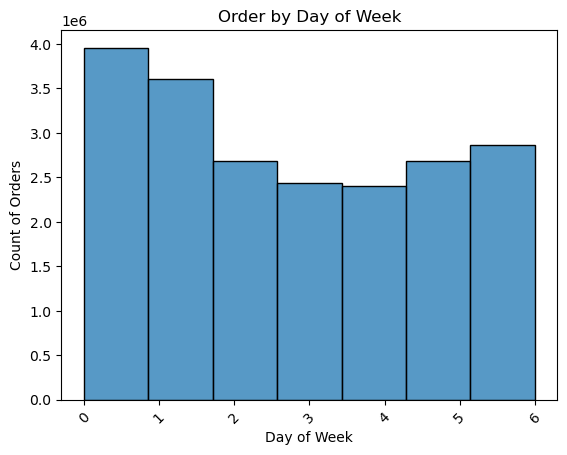

In [54]:
sns.histplot(data=df, x='order_dow', bins=7)
plt.xlabel('Day of Week')
plt.ylabel('Count of Orders')
plt.title('Order by Day of Week')
plt.xticks(rotation= 45)
plt.show()

### Order by Hour of Day

- Shoppers are more likely to place orders in early afternoon

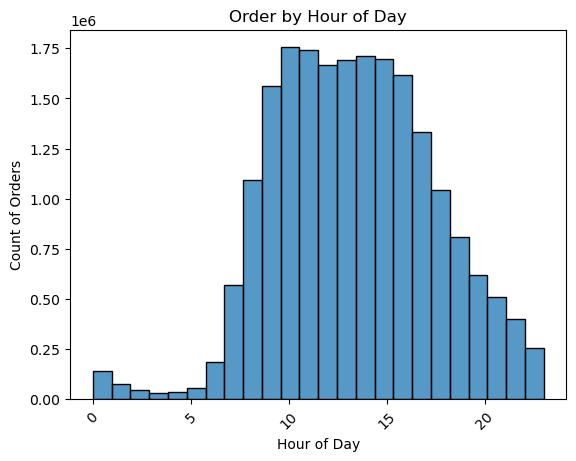

In [55]:
sns.histplot(data=df, x='order_hour_of_day', bins=24)
plt.xlabel('Hour of Day')
plt.xticks(rotation= 45)
plt.ylabel('Count of Orders')
plt.title('Order by Hour of Day')
plt.show()

### Order Frequency 

- most shoppers tend to use the service once a month
- a small group of people orders weekly

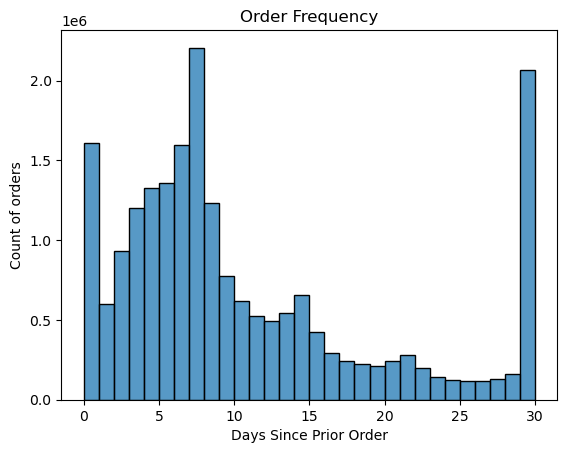

In [56]:
sns.histplot(data=df, x='days_since_prior_order', bins=30)
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count of orders')
plt.title('Order Frequency')
plt.show()

### Orders by Day and Hour
- hotspots for high concentration of orders 10am and 18pm on Monday and Tuesday

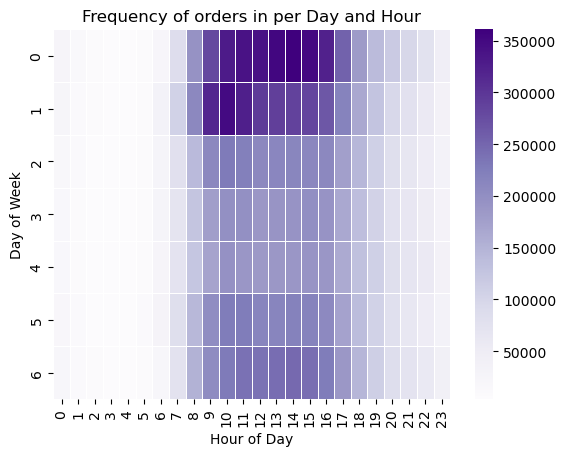

In [57]:
dow_hour = df.groupby(['order_dow', 'order_hour_of_day'])['order_id'].agg('count')\
                                                                     .reset_index()\
                                                                     .rename(columns={'order_id':'orders_count'})\
                                                                     .pivot('order_dow', 'order_hour_of_day', 'orders_count')

ax = sns.heatmap(data=dow_hour, cmap="Purples", linewidths=.5)
plt.title('Frequency of orders in per Day and Hour')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()

### Reorders by Day and Hour
- Suprisingly, a high concentration of reorders happen in the early hours
- Most orders in the afternoon tend to show first order
    - Shoppers feel inclinded to try new products in the afternoon?

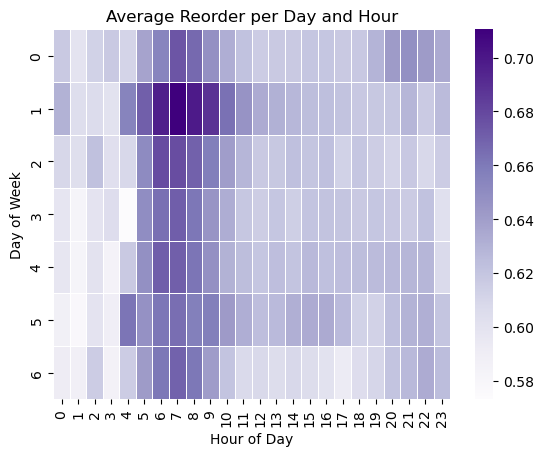

In [58]:
non_first_orders = df['order_number'] != 1

reord_day_hour = df[non_first_orders].groupby(['order_dow', 'order_hour_of_day'])\
                                     .agg({'reordered':'mean'})\
                                     .reset_index()\
                                     .rename(columns={'reordered':'reordered_ratio'})\
                                     .pivot('order_dow', 'order_hour_of_day', 'reordered_ratio')

ax = sns.heatmap(data=reord_day_hour, cmap="Purples",  linewidths=.5)
plt.title('Average Reorder per Day and Hour')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()

### Observations:
- Users shop more actively on Monday and Tuesday - possibly placing order for the week ahead
- A high number of reorders happens between 6 and 9 am on Tuesday - maybe rush reorder shopping during the week due to no time to go to the grocery store?


## User Habits: Number of Orders and Basket Size


### Number of orders

- Order count per user ranges from 3 to 3638
- There are some frequent shoppers who placed over 3000 orders, however they represent a small portion of our sample

In [59]:
# calculating number of orders by user
order_counts = pd.DataFrame(df.groupby('user_id')['order_id'].count())\
                                              .reset_index()\
                                              .rename(columns={'order_id':'order_count'})\
                                              .sort_values(by='order_count', ascending=False)\

order_counts                                           

user_id  order_count
82603    129928         3638
104227   164055         3061
112253   176478         2921
116026   182401         2907
87468    137629         2901
...         ...          ...
79132    124459            3
118675   186553            3
69829    109820            3
44677     70320            3
98184    154527            3

[131209 rows x 2 columns]

In [60]:
order_counts['order_count'].describe()

count    131209.000000
mean        157.321457
std         203.529595
min           3.000000
25%          39.000000
50%          83.000000
75%         189.000000
max        3638.000000
Name: order_count, dtype: float64

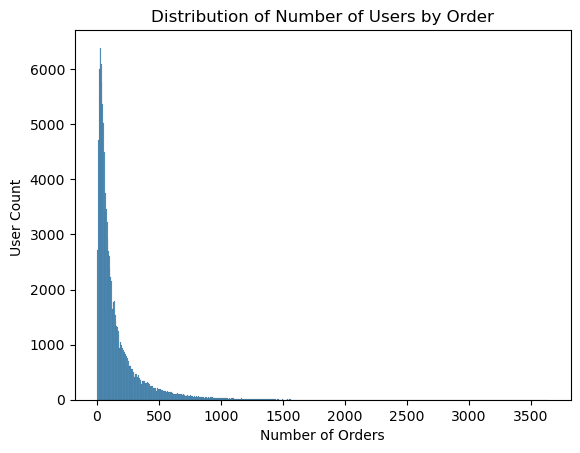

In [61]:
sns.histplot(data=order_counts, x='order_count')
plt.xlabel('Number of Orders')
plt.ylabel('User Count ')
plt.title('Distribution of Number of Users by Order')
plt.show()

### Basket size 
 - Median basket size is around 50 items
 - There are some incredible outliers in our data
     - some users have placed orders for 10000 + items which is skewing the data

In [62]:
user_basket = df.groupby(['user_id', 'order_id'])['add_to_cart_order'].sum()\
                                                                     .reset_index()\
                                                                     .rename(columns={'add_to_cart_order':'basket_size'})

In [63]:
avg_basket = user_basket.groupby('user_id')['basket_size'].mean().reset_index()

In [64]:
avg_basket['basket_size'].describe()

count    131209.0000
mean             NaN
std              NaN
min           1.0000
25%          23.3750
50%          52.4375
75%         106.0000
max        2794.0000
Name: basket_size, dtype: float64

#### Checking Distribution

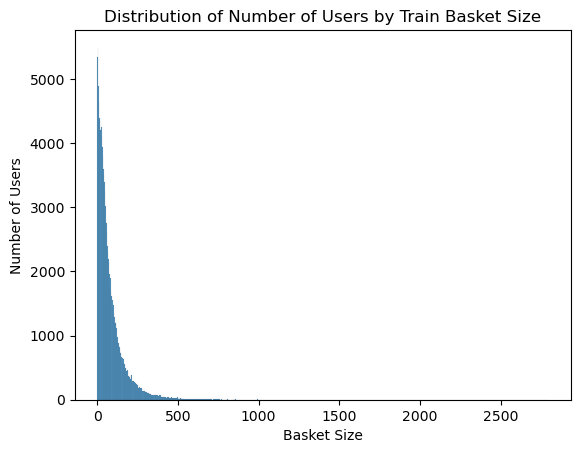

In [65]:
sns.histplot(data=avg_basket, x='basket_size')
plt.xlabel('Basket Size')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Users by Train Basket Size')
plt.show()

#### Checking for outliers

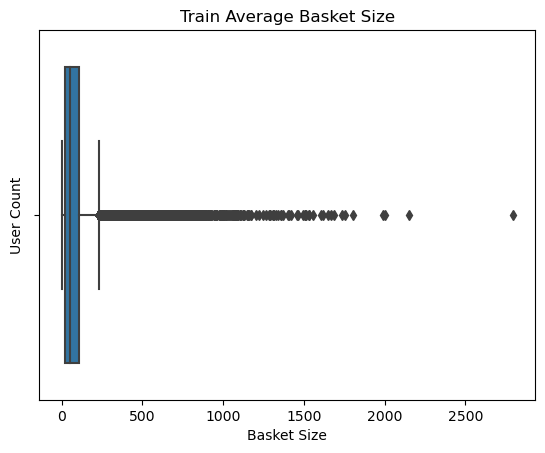

In [66]:
sns.boxplot(x=avg_basket['basket_size'])
plt.title('Train Average Basket Size')
plt.xlabel('Basket Size')
plt.ylabel('User Count')
plt.show();

### Observations
- Median order count for our dataset is 83, and we can see that majority of the users have placed under 100 orders
- Some users have been shopping a whole lot more, but as we can see, they do not represent the majority. Possible business accounts?
- Same goes for average basket size: most users have under 100 items per basket on average, however there seems to be a big skew due to larger order. Again, possible business accounts?

## Product counts

### Product and Aisle by Department

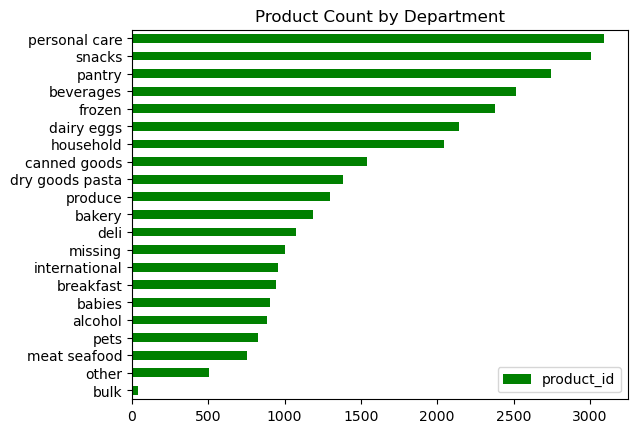

In [67]:
pd.Series(df.groupby('department')['product_id'].nunique()).sort_values(ascending=False).plot(kind='barh', color='g')
pylab.ylabel('')
plt.gca().invert_yaxis()
plt.title('Product Count by Department')
plt.legend(loc='lower right');

### Aisle by Department

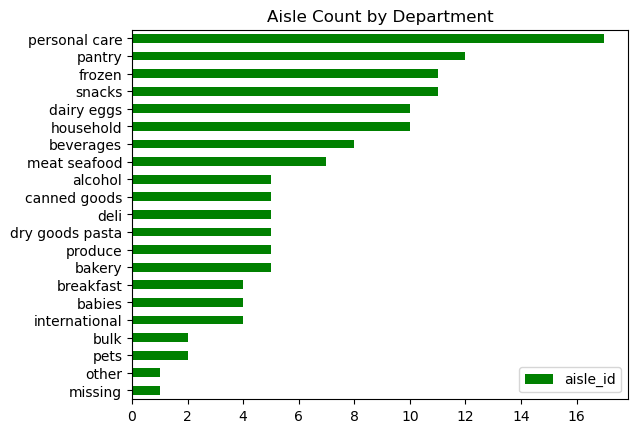

In [68]:
pd.Series(df.groupby('department')['aisle_id'].nunique()).sort_values(ascending=False).plot(kind='barh', color='g')
pylab.ylabel('')
plt.gca().invert_yaxis()
plt.title('Aisle Count by Department')
plt.legend(loc='lower right');

### Aisle

### Aisles with most products

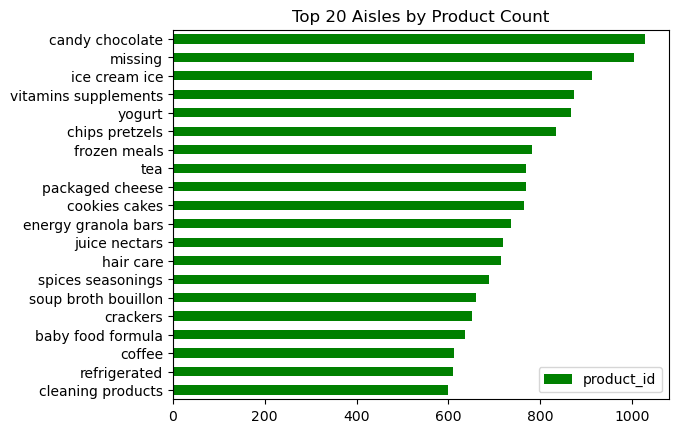

In [69]:
pd.Series(df.groupby('aisle')['product_id'].nunique()).sort_values(ascending=False).head(20).plot(kind='barh', color='g')
pylab.ylabel('')
plt.gca().invert_yaxis()
plt.title('Top 20 Aisles by Product Count')
plt.legend(loc='lower right');

### Aisles with Least Product

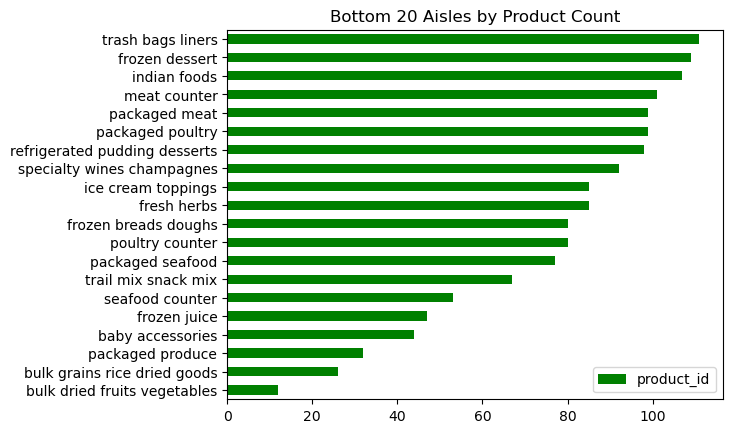

In [70]:
pd.Series(df.groupby('aisle')['product_id'].nunique()).sort_values(ascending=False).tail(20).plot(kind='barh', color='g')
pylab.ylabel('')
plt.gca().invert_yaxis()
plt.title('Bottom 20 Aisles by Product Count')
plt.legend(loc='lower right');

### Observations
- Product and aisle count by department was pretty much as expected, with departments containing most aisles also having most products with slight variations
- Surprised to see that top 3 aisles with most products (not inclusing missing) are not represented in the most reordered top 10 at all

# Machine Learning

In this section, we are going to:
- prepare the data:
    - create the label column
    - create features
- join the data together into a new dataframe which will be used in our modeling
- review the dataset we got
- run some baseline models
- select best models that will be used in out final model
- evaluate our final prediction



## Data Preparation

- With the Prior Orders table as our basis, we will be creating features that will be used in our model to predict whether ot not a given user ordered given product in their latest order (Train set)
    - We will be creating our label 'ordered' by taking the train set, which contains information about the latest order of the users, and comparing it with prior data, creating a list of unique user-product pairs
    - We will aggregate values for each user individually, which will allow us to avoid any data leakage
    - Features will then be appended to our new dataset with user-product pairs and label
    

## Creating the label


### Removing rows from train orders
- where user ordered a product fro the first time in the train set, as we will not have had any data pertaining to that in the prior orders table

In [71]:
train_orders = train_orders[train_orders['reordered']!=0]

### Creating unique user-product pairs present in both prior and train sets

In [72]:
user_product = df[df['user_id'].isin(train_orders['user_id'])]\
                               .drop_duplicates(['user_id', 'product_id'])[['user_id', 'product_id']]\
                               .reset_index(drop=True) 

In [73]:
user_product

user_id  product_id
0              1       196.0
1              1     14080.0
2              1     12424.0
3              1     26080.0
4              1     26400.0
...          ...         ...
8040479   206209     39232.0
8040480   206209     38720.0
8040481   206209     31472.0
8040482   206209      6568.0
8040483   206209     22912.0

[8040484 rows x 2 columns]

### Merging user_product pairs table with train_orders using indicator
- Will help us find whether or not the customer ordered a product on their last order (train set)

In [74]:
merged_df = user_product.merge(train_orders, on=['user_id', 'product_id'], how='left', indicator='present')
merged_df

user_id  product_id   order_id  add_to_cart_order  reordered  \
0              1       196.0  1187899.0                1.0        1.0   
1              1     14080.0        NaN                NaN        NaN   
2              1     12424.0        NaN                NaN        NaN   
3              1     26080.0        NaN                NaN        NaN   
4              1     26400.0        NaN                NaN        NaN   
...          ...         ...        ...                ...        ...   
8040479   206209     39232.0        NaN                NaN        NaN   
8040480   206209     38720.0        NaN                NaN        NaN   
8040481   206209     31472.0        NaN                NaN        NaN   
8040482   206209      6568.0        NaN                NaN        NaN   
8040483   206209     22912.0        NaN                NaN        NaN   

        eval_set  order_number  order_dow  order_hour_of_day  \
0          train          11.0        4.0                8.0   
1            NaN           NaN        NaN                NaN   
2            NaN           NaN        NaN                NaN   
3            NaN           NaN        NaN                NaN   
4            NaN           NaN        NaN                NaN   
...          ...           ...        ...                ...   
8040479      NaN           NaN        NaN                NaN   
8040480      NaN           NaN        NaN                NaN   
8040481      NaN           NaN        NaN                NaN   
8040482      NaN           NaN        NaN                NaN   
8040483      NaN           NaN        NaN                NaN   

         days_since_prior_order    present  
0                          14.0       both  
1                           NaN  left_only  
2                           NaN  left_only  
3                           NaN  left_only  
4                           NaN  left_only  
...                         ...        ...  
8040479                     NaN  left_only  
8040480                     NaN  left_only  
8040481                     NaN  left_only  
8040482                     NaN  left_only  
8040483                     NaN  left_only  

[8040484 rows x 11 columns]

### Creating the target column 'ordered'
- adding 1 if the pair is present in both, 0 if the pair is not

In [75]:
user_product['ordered'] = (merged_df['present'] == 'both').astype(int)

In [155]:
user_product

user_id  product_id  ordered
0              1       196.0        1
1              1     14080.0        0
2              1     12424.0        0
3              1     26080.0        0
4              1     26400.0        0
...          ...         ...      ...
8040479   206209     39232.0        0
8040480   206209     38720.0        0
8040481   206209     31472.0        0
8040482   206209      6568.0        0
8040483   206209     22912.0        0

[8040484 rows x 3 columns]

## Feature Engineering


In [366]:
# Chaning datatypes for these columns to avoid errors when merging
df['aisle_id'] = df['aisle_id'].astype(float)
df['department_id'] = df['department_id'].astype(float)



### Aggregating Prior Orders Table

### Day of Week and Hour

- Calculating mode to find out what day and hour each user places orders most frequently

In [77]:
# Day of Week
freq_dow = pd.DataFrame(df.groupby(['user_id', 'product_id'])['order_dow']\
                                         .agg(lambda x: x.mode().iloc[-1]))\ #applying mode and selecting the last value for ease of computing
                                         .reset_index()\
                                         .rename(columns={'order_dow':'prior_freq_dow'})

In [78]:
freq_dow

user_id  product_id  prior_freq_dow
0              1       196.0               4
1              1     10256.0               4
2              1     10328.0               4
3              1     12424.0               4
4              1     13032.0               4
...          ...         ...             ...
8306757   206209     43968.0               1
8306758   206209     44320.0               2
8306759   206209     48384.0               4
8306760   206209     48704.0               2
8306761   206209     48736.0               2

[8306762 rows x 3 columns]

In [79]:
# Hour of Day
freq_hour = pd.DataFrame(df.groupby(['user_id', 'product_id'])['order_hour_of_day']\
                                         .agg(lambda x: x.mode().iloc[-1]))\
                                         .reset_index()\
                                         .rename(columns={'order_hour_of_day':'prior_freq_hour'})

In [80]:
freq_hour

user_id  product_id  prior_freq_hour
0              1       196.0                7
1              1     10256.0                7
2              1     10328.0               15
3              1     12424.0                7
4              1     13032.0                9
...          ...         ...              ...
8306757   206209     43968.0               17
8306758   206209     44320.0               13
8306759   206209     48384.0               10
8306760   206209     48704.0               13
8306761   206209     48736.0               13

[8306762 rows x 3 columns]

### Calculating total times a customer ordered a product 

In [81]:
product_by_user = pd.DataFrame(df.groupby(['user_id', 'product_id'])['add_to_cart_order']\
                                           .sum())\
                                           .reset_index()\
                                           .rename(columns={'add_to_cart_order':'prior_total_prod_by_user'})

In [82]:
product_by_user

user_id  product_id  prior_total_prod_by_user
0              1       196.0                      14.0
1              1     10256.0                      30.0
2              1     10328.0                       5.0
3              1     12424.0                      33.0
4              1     13032.0                      19.0
...          ...         ...                       ...
8306757   206209     43968.0                      24.0
8306758   206209     44320.0                       8.0
8306759   206209     48384.0                       8.0
8306760   206209     48704.0                       6.0
8306761   206209     48736.0                      18.0

[8306762 rows x 3 columns]

### Calculating average product count by user basket 
- how many of each product user adds to basket

In [83]:
product_per_basket = pd.DataFrame(df.groupby(['user_id', 'product_id'])['add_to_cart_order']\
                                              .mean())\
                                              .reset_index()\
                                              .rename(columns={'add_to_cart_order':'prior_avg_prod_by_basket'})

In [84]:
product_per_basket

user_id  product_id  prior_avg_prod_by_basket
0              1       196.0                  1.400391
1              1     10256.0                  3.333984
2              1     10328.0                  5.000000
3              1     12424.0                  3.300781
4              1     13032.0                  6.332031
...          ...         ...                       ...
8306757   206209     43968.0                  8.000000
8306758   206209     44320.0                  8.000000
8306759   206209     48384.0                  8.000000
8306760   206209     48704.0                  6.000000
8306761   206209     48736.0                  9.000000

[8306762 rows x 3 columns]

### Calculating order frequency per user
- how often the user places orders

In [85]:
order_frequency = pd.DataFrame(df.groupby(['user_id'])['days_since_prior_order']\
                                           .mean()\
                                           .round(decimals = 2))\
                                           .reset_index()\
                                           .rename(columns={'days_since_prior_order':'prior_avg_order_frequency'})

In [86]:
order_frequency

user_id  prior_avg_order_frequency
0             1                  18.546875
1             2                  14.906250
2             5                  10.187500
3             7                  12.757812
4             8                  17.140625
...         ...                        ...
131204   206199                  17.203125
131205   206200                   6.281250
131206   206203                  23.718750
131207   206205                   9.687500
131208   206209                  18.234375

[131209 rows x 2 columns]

### Product Order Frequency
- how often each product is ordered by user

In [ ]:
prod_frequency = pd.DataFrame(df.groupby(['user_id', 'product_id'])['days_since_prior_order']\
                                  .mean()\
                                  .round(decimals = 0))\
                                  .rename(columns={'days_since_prior_order':'prod_reorder_frequency'})\
                                  .reset_index()

In [339]:
prod_frequency

user_id  product_id  prod_reorder_frequency
0              1       196.0                    18.0
1              1     10256.0                    20.0
2              1     10328.0                    28.0
3              1     12424.0                    18.0
4              1     13032.0                    22.0
...          ...         ...                     ...
8306757   206209     43968.0                    23.0
8306758   206209     44320.0                     9.0
8306759   206209     48384.0                    30.0
8306760   206209     48704.0                     9.0
8306761   206209     48736.0                    14.0

[8306762 rows x 3 columns]

### Aisle reorder frequency
- how often user reorders from aisle

In [367]:
aisle_frequency = pd.DataFrame(df.groupby(['user_id', 'aisle_id'])['days_since_prior_order']\
                                  .mean()\
                                  .round(decimals = 0))\
                                  .rename(columns={'days_since_prior_order':'aisle_reorder_frequency'})\
                                  .reset_index()

In [368]:
aisle_frequency

user_id  aisle_id  aisle_reorder_frequency
0              1      21.0                     20.0
1              1      23.0                     16.0
2              1      24.0                     25.0
3              1      45.0                     30.0
4              1      53.0                      7.0
...          ...       ...                      ...
3647694   206209     120.0                     17.0
3647695   206209     121.0                     16.0
3647696   206209     123.0                     21.0
3647697   206209     130.0                     11.0
3647698   206209     131.0                      9.0

[3647699 rows x 3 columns]

### Department reorder frequency
- how oftern user reorders from department

In [369]:
dept_frequency = pd.DataFrame(df.groupby(['user_id', 'department_id'])['days_since_prior_order']\
                                  .mean()\
                                  .round(decimals = 0))\
                                  .rename(columns={'days_since_prior_order':'dept_reorder_frequency'})\
                                  .reset_index()

In [370]:
dept_frequency

user_id  department_id  dept_reorder_frequency
0              1            4.0                    25.0
1              1            7.0                    17.0
2              1           13.0                    21.0
3              1           14.0                    22.0
4              1           16.0                    18.0
...          ...            ...                     ...
1421160   206209           15.0                    17.0
1421161   206209           16.0                    17.0
1421162   206209           17.0                    24.0
1421163   206209           19.0                    17.0
1421164   206209           20.0                    22.0

[1421165 rows x 3 columns]

### Product Reorder Ratio per user
- reorder ratio for each product per user 
- reorder ratio of value 1 was taken

In [127]:
ratios = pd.DataFrame(df.groupby(['user_id', 'product_id'])['reordered']\
                                  .value_counts(normalize=True))\
                                  .rename(columns={'reordered':'product_reorder_ratio'})\
                                  .reset_index()

In [128]:
# filtering out positive values only
prod_reorder_ratio = ratios[ratios['reordered']==1]

In [337]:
# dropping reoreded column to avoid errors during merging
prod_reorder_ratio = prod_reorder_ratio.drop(columns='reordered').reset_index(drop=True)

In [355]:
prod_reorder_ratio

user_id  product_id  product_reorder_ratio
0              1       196.0               0.900000
1              1     10256.0               0.888889
2              1     12424.0               0.900000
3              1     13032.0               0.666667
4              1     13176.0               0.500000
...          ...         ...                    ...
3357498   206209     40544.0               0.500000
3357499   206209     40992.0               0.666667
3357500   206209     41216.0               0.857143
3357501   206209     43968.0               0.666667
3357502   206209     48736.0               0.500000

[3357503 rows x 3 columns]

### Aisle reorder ratio
- reorder ratio for each aisle per user 
- reorder ratio of value 1 was taken

In [371]:
ratios = pd.DataFrame(df.groupby(['user_id', 'aisle_id'])['reordered']\
                                  .value_counts(normalize=True))\
                                  .rename(columns={'reordered':'aisle_reorder_ratio'})\
                                  .reset_index()

In [372]:
aisle_reorder_ratio = ratios[ratios['reordered']==1]
aisle_reorder_ratio = aisle_reorder_ratio.drop(columns='reordered').reset_index(drop=True)
aisle_reorder_ratio

user_id  aisle_id  aisle_reorder_ratio
0              1      21.0             0.875000
1              1      23.0             0.833333
2              1      24.0             0.200000
3              1      53.0             0.500000
4              1      54.0             0.500000
...          ...       ...                  ...
1805914   206209     108.0             0.500000
1805915   206209     112.0             0.750000
1805916   206209     121.0             0.333333
1805917   206209     123.0             0.400000
1805918   206209     130.0             0.333333

[1805919 rows x 3 columns]

### Departement Reorder Ratio
- reorder ratio for each department per user 
- reorder ratio of value 1 was taken

In [373]:
ratios = pd.DataFrame(df.groupby(['user_id', 'department_id'])['reordered']\
                                  .value_counts(normalize=True))\
                                  .rename(columns={'reordered':'dept_reorder_ratio'})\
                                  .reset_index()

In [374]:
dept_reorder_ratio = ratios[ratios['reordered']==1]
dept_reorder_ratio = dept_reorder_ratio.drop(columns='reordered').reset_index(drop=True)
dept_reorder_ratio

user_id  department_id  dept_reorder_ratio
0             1            4.0            0.200000
1             1            7.0            0.846154
2             1           14.0            0.666667
3             1           16.0            0.615385
4             1           17.0            0.500000
...         ...            ...                 ...
895069   206209           15.0            0.428571
895070   206209           16.0            0.535714
895071   206209           17.0            0.428571
895072   206209           19.0            0.181818
895073   206209           20.0            0.333333

[895074 rows x 3 columns]

### Calculating Average Basket size by user
- avearge basket size per user

In [91]:
# calculate basket size per each order per customer
basket_per_order = pd.DataFrame(df.groupby(['user_id', 'order_id'])['add_to_cart_order']
                                            .sum())\
                                            .reset_index()

In [92]:
basket_per_order

user_id  order_id  add_to_cart_order
0              1    431534               36.0
1              1    473747               15.0
2              1    550135               15.0
3              1   2254736               15.0
4              1   2295261               21.0
...          ...       ...                ...
2047372   206209   2307371                6.0
2047373   206209   2558525                6.0
2047374   206209   2977660               45.0
2047375   206209   3154581               91.0
2047376   206209   3186442                3.0

[2047377 rows x 3 columns]

In [93]:
# calculate average basket size
average_basket = pd.DataFrame(basket_per_order.groupby('user_id')['add_to_cart_order']\
                             .mean())\
                             .round(decimals = 0)\
                             .reset_index()\
                             .rename(columns={'add_to_cart_order':'prior_average_basket'})

In [94]:
average_basket

user_id  prior_average_basket
0             1                  21.0
1             2                 119.0
2             5                  51.0
3             7                  75.0
4             8                 147.0
...         ...                   ...
131204   206199                 178.0
131205   206200                 101.0
131206   206203                 302.0
131207   206205                  72.0
131208   206209                  67.0

[131209 rows x 2 columns]

### Product NLP

- checking if product is 'is_healthy'
    - products that contain words like 'organic', 'natural, 'free' (usually goes with dairy-free, odour-free etc.), 'whole'

In [95]:
vectorizer = CountVectorizer()

prod_corpus = products['product_name']

X_prod = vectorizer.fit_transform(prod_corpus)

bow_df = pd.DataFrame(X_prod.toarray(), columns=vectorizer.get_feature_names_out())

In [96]:
bow_df.sum(axis='rows').sort_values(ascending=False).head(30)

organic      5030
chocolate    2448
with         2236
free         2197
cheese       2095
chicken      1540
original     1452
sauce        1291
cream        1285
yogurt       1161
mix          1147
natural      1131
milk         1106
tea          1101
whole        1076
and          1071
vanilla      1054
butter       1054
white        1038
rice         1001
bar          1001
fruit         994
in            959
juice         955
food          940
oil           932
coconut       834
sweet         833
gluten        821
100           817
dtype: int64

In [117]:
products['is_healthy'] = products['product_name'].str.lower()\
                                                 .str.contains('organic|natural|free|whole', regex=True)\
                                                 .astype(int)

In [241]:
products = products.drop(columns='product_name')

In [242]:
products

product_id  aisle_id  department_id  is_healthy
0               1        61             19           0
1               2       104             13           0
2               3        94              7           0
3               4        38              1           0
4               5         5             13           0
...           ...       ...            ...         ...
49683       49684       124              5           0
49684       49685        42              1           0
49685       49686       112              3           0
49686       49687        41              8           0
49687       49688        73             11           0

[49688 rows x 4 columns]

## Merging the tables
 - Following the schema, we will proceed to merge tables into full dataset
 - Full table size: 1384617 rows and 22 columns 

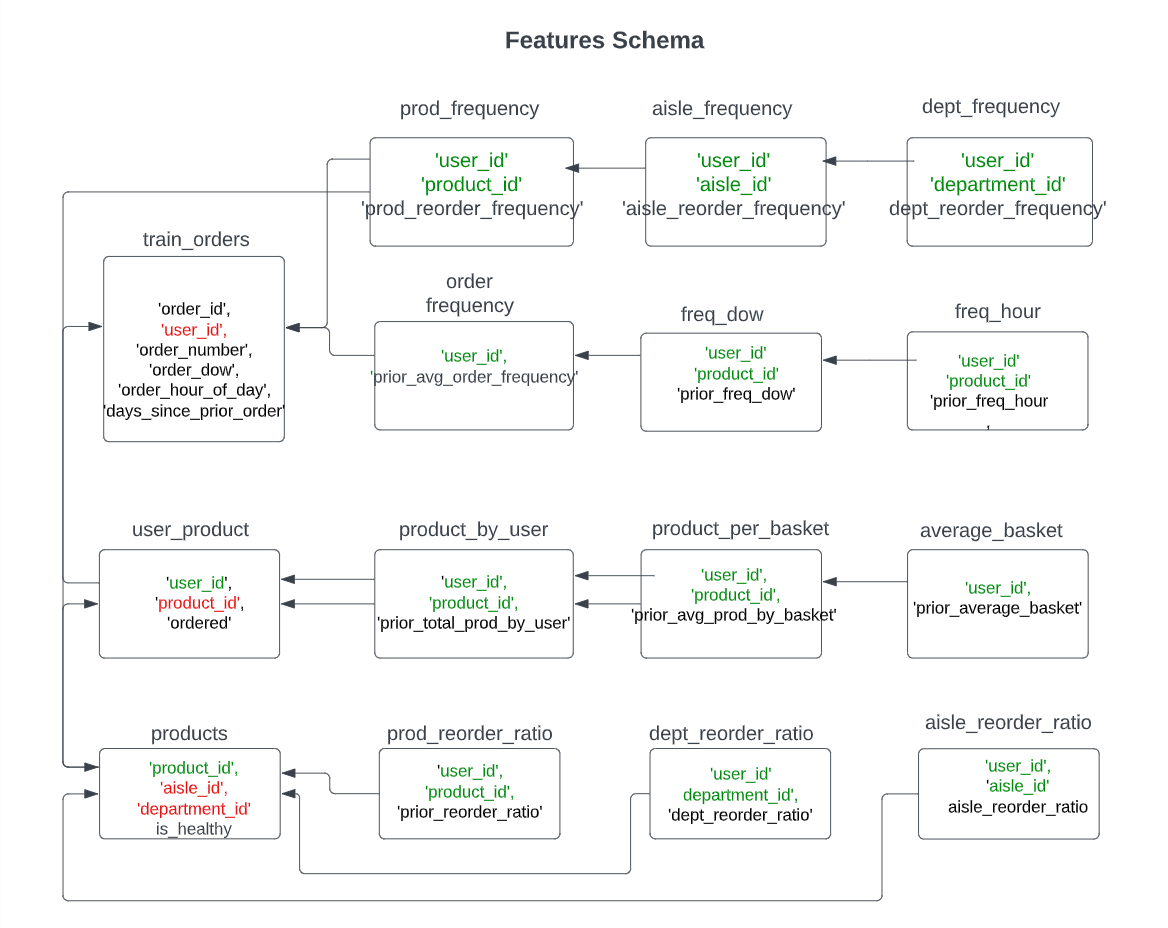

### Filtering train_orders
- The data from user_product pairs ended up being 8 million rows and when joined with train_orders, became even larger
- For this project, we will be using a subset of the data of 1000 users
- Since the label is so imbalanced, I decided to do a targeted sampling:
    - we will be taking top 1000 users with most product_ids in their last order 
    - we were able to increase positive class by almost 1%

### Calculating order sizes by rows

In [223]:
order_sizes = train_orders.groupby('order_id').size().reset_index(name='order_size')

In [225]:
# attaching order size to train_orders to be used as a filter
train_orders = train_orders.merge(order_sizes, on='order_id')

In [ ]:
train_sorted = train_info.sort_values(by='order_size', ascending=False)

### Dropping unwanted columns in the dataset and removing duplicates

In [231]:
train_info = train_orders.drop(columns=['order_id','product_id', 'add_to_cart_order', 'reordered', 'eval_set'])\
                         .drop_duplicates(subset=['user_id'])

### Merging the to 10000 users from train_orders with user_product table

In [268]:
data = train_sorted.head(10000).merge(user_product, on='user_id', how='left')

In [239]:
user_product['ordered'].value_counts(normalize=True)*100

0    98.638017
1     1.361983
Name: ordered, dtype: float64

In [237]:
data['ordered'].value_counts(normalize=True)*100

0    97.774409
1     2.225591
Name: ordered, dtype: float64

### Merging the rest of the tables

In [379]:
full_df = data.merge(products, on=['product_id'], how='left')\
                .merge(product_by_user, on=['user_id','product_id'], how='left')\
                .merge(product_per_basket, on=['user_id','product_id'], how='left')\
                .merge(average_basket, on='user_id', how='left')\
                .merge(order_frequency, on='user_id', how='left')\
                .merge(freq_dow, on=['user_id','product_id'], how='left')\
                .merge(freq_hour, on=['user_id','product_id'], how='left')\
                .merge(prod_reorder_ratio, on=['user_id','product_id'], how='left')\
                .merge(dept_reorder_ratio, on=['user_id','department_id'], how='left')\
                .merge(aisle_reorder_ratio, on=['user_id','aisle_id'], how='left')\
                .merge(prod_frequency, on=['user_id','product_id'], how='left')\
                .merge(aisle_frequency, on=['user_id','aisle_id'], how='left')\
                .merge(dept_frequency, on=['user_id','department_id'], how='left')

## Imputing null values
Our final dataset had some missing values due about 40% of our product orders being first time purchases

In [ ]:
full_df.isnull().sum()

### Missing product information
- noticed that product_id 49696 was not present in the original products table
    - 2664 rows rows dropped 

In [288]:
full_df[full_df['aisle_id'].isnull()==True]

user_id  order_number  order_dow  order_hour_of_day  \
1308      100330            58          5                 12   
1917      163724             9          6                 16   
2377      185920            62          3                 17   
3026      148812            46          6                 21   
3136       83836             4          4                 15   
...          ...           ...        ...                ...   
1260429   129321            41          5                 15   
1260680   201628            11          5                 13   
1261140    40391            23          0                  9   
1261992    43765            21          3                 11   
1262588    19020            76          6                 11   

         days_since_prior_order  order_size  product_id  ordered  aisle_id  \
1308                        9.0          61     49696.0        0       NaN   
1917                       30.0          59     49696.0        0       NaN   
2377                       10.0          55     49696.0        0       NaN   
3026                        2.0          54     49696.0        0       NaN   
3136                        0.0          53     49696.0        0       NaN   
...                         ...         ...         ...      ...       ...   
1260429                     8.0          16     49696.0        0       NaN   
1260680                     7.0          16     49696.0        0       NaN   
1261140                    14.0          16     49696.0        0       NaN   
1261992                    16.0          16     49696.0        0       NaN   
1262588                     6.0          16     49696.0        0       NaN   

         department_id  is_healthy  prior_total_prod_by_user  \
1308               NaN         NaN                       3.0   
1917               NaN         NaN                      96.0   
2377               NaN         NaN                     230.0   
3026               NaN         NaN                      37.0   
3136               NaN         NaN                      13.0   
...                ...         ...                       ...   
1260429            NaN         NaN                      45.0   
1260680            NaN         NaN                      18.0   
1261140            NaN         NaN                      13.0   
1261992            NaN         NaN                      12.0   
1262588            NaN         NaN                      28.0   

         prior_avg_prod_by_basket  prior_average_basket  \
1308                     3.000000                1090.0   
1917                    32.000000                1648.0   
2377                    13.531250                 186.0   
3026                    12.335938                 418.0   
3136                     6.500000                 642.0   
...                           ...                   ...   
1260429                 11.250000                 195.0   
1260680                  6.000000                 225.0   
1261140                  6.500000                 228.0   
1261992                 12.000000                 264.0   
1262588                 28.000000                 142.0   

         prior_avg_order_frequency  prior_freq_dow  prior_freq_hour  \
1308                      6.699219               1               13   
1917                     13.601562               4               19   
2377                      5.699219               4               16   
3026                      7.339844               0               10   
3136                     26.000000               6               19   
...                            ...             ...              ...   
1260429                   9.257812               0               15   
1260680                  20.812500               6               19   
1261140                  10.757812               1               17   
1261992                  15.328125               0                9   
1262588                   5.398438          

In [382]:
full_df = full_df[full_df['product_id']!=49696.0]

### Reorder ratios and reorder frequency
- When creating the reorder tables, only values of 1 were kept
- if product was not reordered, value would have been dropped, resulting in Null values when merging
- WIll be imputed with 0, since this is an indication that the product was never reordered
- Same with aisle and dept reorder ratio, NaN values would have appeared if the user never reordered form the aisle or department. will be imputing with 0

In [383]:
full_df = full_df.fillna(0)

In [385]:
# Saving cleaned dataset to csv
full_df.to_csv('full_df.csv', index=False)

## Reviewing our final dataset

In [30]:
full_df = pd.read_csv('full_df.csv')
reduce_memory(full_df)

Memory usage of dataframe is: 221.11 MB
Memory usage after optimization: 51.67 MB
Reduced by 76.6%.


user_id  order_number  order_dow  order_hour_of_day  \
0         181991            51          0                 21   
1         181991            51          0                 21   
2         181991            51          0                 21   
3         181991            51          0                 21   
4         181991            51          0                 21   
...          ...           ...        ...                ...   
1260052   184144            21          3                 13   
1260053   184144            21          3                 13   
1260054   184144            21          3                 13   
1260055   184144            21          3                 13   
1260056   184144            21          3                 13   

         days_since_prior_order  order_size  product_id  ordered  aisle_id  \
0                           6.0          71        7692        0     114.0   
1                           6.0          71        7780        0      31.0   
2                           6.0          71       27344        1      96.0   
3                           6.0          71       46816        0     102.0   
4                           6.0          71        8312        0      94.0   
...                         ...         ...         ...      ...       ...   
1260052                    18.0          16       19024        0       9.0   
1260053                    18.0          16       19760        0      63.0   
1260054                    18.0          16        6448        0      23.0   
1260055                    18.0          16       11344        0      54.0   
1260056                    18.0          16         343        1     123.0   

         department_id  ...  prior_average_basket  prior_avg_order_frequency  \
0                 17.0  ...                1458.0                   7.820312   
1                  7.0  ...                1458.0                   7.820312   
2                 20.0  ...                1458.0                   7.820312   
3                 18.0  ...                1458.0                   7.820312   
4                  7.0  ...                1458.0                   7.820312   
...                ...  ...                   ...                        ...   
1260052            9.0  ...                 187.0                  16.718750   
1260053            9.0  ...                 187.0                  16.718750   
1260054           19.0  ...                 187.0                  16.718750   
1260055           17.0  ...                 187.0                  16.718750   
1260056            4.0  ...                 187.0                  16.718750   

         prior_freq_dow  prior_freq_hour  product_reorder_ratio  \
0                     1               12               0.750000   
1                     1                7               0.967773   
2                     1                7               0.971191   
3                     1                7               0.964355   
4                     1               10               0.956543   
...                 ...              ...                    ...   
1260052               6               12               0.500000   
1260053               6               12               0.500000   
1260054               6               12               0.500000   
1260055               6               12               0.500000   
1260056               6               12               0.000000   

         dept_reorder_ratio  aisle_reorder_ratio  prod_reorder_frequency  \
0                  0.000000             0.000000                     4.0   
1                  0.887695             0.799805                     8.0   
2                  0.913086             0.921875                     8.0   
3                  0.000000             0.000000                     7.0   
4                  0.887695             0.827148                     9.0   
...                     ...                  ...                     ...   
12600

In [22]:
full_df.shape

(1260057, 23)

In [46]:
full_df.describe()

user_id  order_number     order_dow  order_hour_of_day  \
count  1.260057e+06  1.260057e+06  1.260057e+06       1.260057e+06   
mean   1.024635e+05  3.137507e+01  2.673067e+00       1.333397e+01   
std    5.907786e+04  2.154545e+01  2.239886e+00       4.390952e+00   
min    9.000000e+00  4.000000e+00  0.000000e+00       0.000000e+00   
25%    5.147200e+04  1.400000e+01  0.000000e+00       1.000000e+01   
50%    1.024560e+05  2.600000e+01  2.000000e+00       1.300000e+01   
75%    1.536660e+05  4.400000e+01  5.000000e+00       1.600000e+01   
max    2.061530e+05  1.000000e+02  6.000000e+00       2.300000e+01   

       days_since_prior_order    order_size    product_id       ordered  \
count               1260057.0  1.260057e+06  1.260057e+06  1.260057e+06   
mean                      NaN  2.226930e+01  2.523456e+04  2.230296e-02   
std                       0.0  6.387768e+00  1.419622e+04  1.476670e-01   
min                       0.0  1.600000e+01  1.000000e+00  0.000000e+00   
25%                       6.0  1.800000e+01  1.317600e+04  0.000000e+00   
50%                       9.0  2.000000e+01  2.515200e+04  0.000000e+00   
75%                      19.0  2.500000e+01  3.769600e+04  0.000000e+00   
max                      30.0  7.100000e+01  4.966400e+04  1.000000e+00   

        aisle_id  department_id  ...  prior_average_basket  \
count  1260057.0      1260057.0  ...             1260057.0   
mean         NaN            NaN  ...                   NaN   
std          0.0            0.0  ...                   NaN   
min          1.0            1.0  ...                  17.0   
25%         36.0            7.0  ...                 145.0   
50%         70.0           13.0  ...                 219.0   
75%        102.0           17.0  ...                 329.0   
max        134.0           21.0  ...                2152.0   

       prior_avg_order_frequency  prior_freq_dow  prior_freq_hour  \
count               1.260057e+06    1.260057e+06     1.260057e+06   
mean                         NaN    3.026682e+00     1.437879e+01   
std                 0.000000e+00    2.176993e+00     4.311960e+00   
min                 4.499512e-01    0.000000e+00     0.000000e+00   
25%                 7.199219e+00    1.000000e+00     1.100000e+01   
50%                 9.937500e+00    3.000000e+00     1.400000e+01   
75%                 1.392969e+01    5.000000e+00     1.700000e+01   
max                 2.945312e+01    6.000000e+00     2.300000e+01   

       product_reorder_ratio  dept_reorder_ratio  aisle_reorder_ratio  \
count           1.260057e+06        1.260057e+06         1.260057e+06   
mean                     NaN                 NaN                  NaN   
std             0.000000e+00        0.000000e+00         0.000000e+00   
min             0.000000e+00        0.000000e+00         0.000000e+00   
25%             0.000000e+00        0.000000e+00         0.000000e+00   
50%             5.000000e-01        4.721680e-01         0.000000e+00   
75%             6.665039e-01        6.816406e-01         5.000000e-01   
max             9.897461e-01        9.790039e-01         9.892578e-01   

       prod_reorder_frequency  aisle_reorder_frequency  dept_reorder_frequency  
count               1260057.0                1260057.0               1260057.0  
mean                      NaN                      NaN                     NaN  
std                       0.0                      0.0                     0.0  
min                       0.0                      0.0                     0.0  
25%                       6.0                      0.0                     5.0  
50%                       8.0                      3.0                     8.0  
75%                      14.0                      9.0                    13.0  
max                      30.0                     30.0                    30.0  

[8 rows x 23 columns]

### Data types
- Most of the columns we are going to be using in our modeling are continuous values
- Columns pertaining to day of week and hour of day need to be converted to categorical values
- Unique identifier columns will not be used in our modeling, so we can leave them be

In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260057 entries, 0 to 1260056
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   user_id                    1260057 non-null  int64  
 1   order_number               1260057 non-null  int64  
 2   order_dow                  1260057 non-null  int64  
 3   order_hour_of_day          1260057 non-null  int64  
 4   days_since_prior_order     1260057 non-null  float64
 5   order_size                 1260057 non-null  int64  
 6   product_id                 1260057 non-null  int64  
 7   ordered                    1260057 non-null  int64  
 8   aisle_id                   1260057 non-null  float64
 9   department_id              1260057 non-null  float64
 10  is_healthy                 1260057 non-null  float64
 11  prior_total_prod_by_user   1260057 non-null  float64
 12  prior_avg_prod_by_basket   1260057 non-null  float64
 13  prior_averag

In [338]:
# Changing datatypes to category
columns = ['order_dow', 'order_hour_of_day', 'prior_freq_dow', 'prior_freq_hour', 'product_id', 'aisle_id', 'department_id', 'user_id']
full_df[columns] = full_df[columns].astype('category')

In [339]:
# These values can be ordered
full_df['order_dow'] = full_df['order_dow'].cat.as_ordered()
full_df['order_hour_of_day'] = full_df['order_hour_of_day'].cat.as_ordered()
full_df['prior_freq_dow'] = full_df['prior_freq_dow'].cat.as_ordered()
full_df['prior_freq_hour'] = full_df['prior_freq_hour'].cat.as_ordered()

### Label

- Our target is very imbalanced = only 2% is positive class
- Will have to rectify that by using some sort of over/under sampling

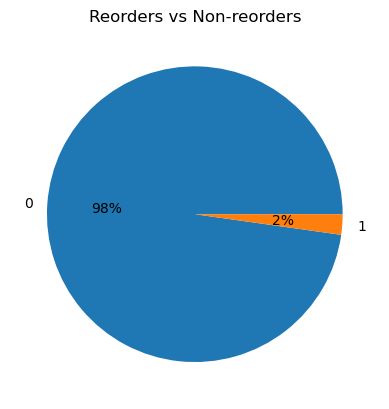

In [4]:
full_df['ordered'].value_counts(normalize=True).plot(kind='pie', title='Reorders vs Non-reorders', autopct='%.0f%%', )
pylab.ylabel('');

## Modeling
- We are going to test several models that have been commonly used for similar problems
    - Logistic Regression
    - Decision Trees
    - XGBoost
    - LightGBM
    - Keras Model
    
- Evaluation metrics will be:
    - f1 score
        - our target is very unbalanced, so relying on accuracy will not work since our model will predict 0 very precisely
    - ROC AUC 
        - better indicator for imbalanced datasets
       

### Pipeline
Steps:
- ColumnTransformer:
    - separated columns into nums = numeric, one_hot_cats = categories to one-hot encode and freq_cats = categories to frequency encode
    - MinMaxScaler() performed better during test runs compared to standard scaler
        - There are no huge outliers in this dataset due to it's nature, so scaling should be sufficient
    - RareLabelEncoder() needed to be used on freq_cats before CountEncoder due to the CountEncoder() creating NaN values 
- RandomUnderSampler() 
    - performed better during test runs compared to over samling
- Model - variable to be reset 

In [372]:
nums = ['order_number','days_since_prior_order', 'order_size', 'prior_total_prod_by_user',
       'prior_avg_prod_by_basket', 'prior_average_basket', 'prior_avg_order_frequency',
       'product_reorder_ratio', 'dept_reorder_ratio', 'aisle_reorder_ratio',
       'prod_reorder_frequency', 'aisle_reorder_frequency', 'dept_reorder_frequency']

one_hot_cats = ['order_dow', 'order_hour_of_day', 'prior_freq_dow', 'prior_freq_hour', 'is_healthy']

freq_cats = ['user_id', 'product_id', 'aisle_id', 'department_id']

In [387]:
transformers = [('scaler', MinMaxScaler(), nums), 
                ('oh_encoding', OneHotEncoder(drop='first'), one_hot_cats),
                ('rare_encoding', RareLabelEncoder(replace_with=0), freq_cats),
                ('freq_encoding', CountEncoder(), freq_cats)]


preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [388]:
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('rus', RandomUnderSampler(random_state=13)),
    ('model', model)    
])

### Splitting our data into train, val and test sets
- Using holdout validation, since cross-validation is still going to be used during grid search

In [375]:
X = full_df.drop(columns=['ordered'])
y = full_df['ordered']

In [376]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

### Baseline Models

In [357]:
# Manually frequency encoding to mimic data after preprocessing

columns_to_encode = ['user_id', 'product_id', 'aisle_id', 'department_id']
X_try = X.copy()
X_try = frequency_encode_columns(X_try, columns_to_encode)

In [360]:
# one hot encoding
X_trans = pd.get_dummies(X_try, drop_first=True)

In [362]:
%%time
baseline(X_trans, y, 13)

D:\Users\Opekh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\Opekh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression(max_iter=1000, random_state=13) avg f1: 0.03866749155509879
DecisionTreeClassifier(random_state=13) avg f1: 0.19462589930106064
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=13, ...) avg f1: 0.07128389790578482
LGBMClassifier(random_state=13) avg f1: 0.11719929070610884
Wall time: 43mi

### Model Training, Validation and Hyperparameter Tuning
- As mentioned earlier, holdout validation was used for this dataset due to the fact that a neural network will be used in this project, as well as GridSearchCV can assist with cross-validation and overfitting

- In this section, we will be trying 4 models and see if the scores improves if we stack them

### Logistic regression

In [390]:
%%time

model = LogisticRegression()

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('rus', RandomUnderSampler(random_state=13)),
    ('model', model)    
])

param_grid = {
    'model__max_iter': [1000],
    'model__random_state':[13],
    'model__C':[.01,.05,.1,.5,1,5,10],
    'model__penalty':['l2']
    }

lr_search = GridSearchCV(pipe, param_grid=param_grid, cv = 5, verbose = True, n_jobs = -1, scoring='f1_macro')

lr_search.fit(X_train, y_train)

print(f'best parameters:', lr_search.best_params_)
lr_search.best_score_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
best parameters: {'model__C': 0.01, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__random_state': 13}
Wall time: 48.3 s


0.3820393219623558

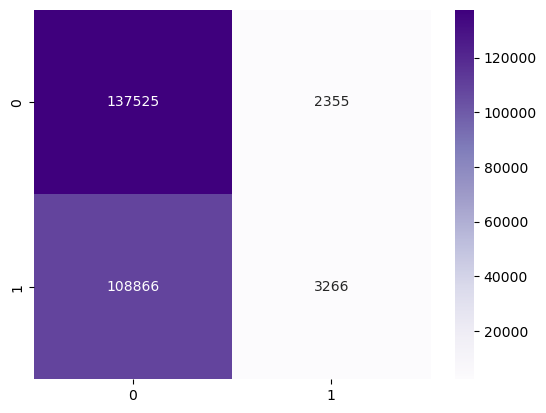

              precision    recall  f1-score   support

           0       0.56      0.98      0.71    139880
           1       0.58      0.03      0.06    112132

    accuracy                           0.56    252012
   macro avg       0.57      0.51      0.38    252012
weighted avg       0.57      0.56      0.42    252012



In [528]:
lr = lr_search.best_estimator_

lr.fit(X_train,y_train)

y_val_pred = lr.predict(X_val)

reports(y_val_pred, y_val)

Area under curve :  0.5061452637252425 



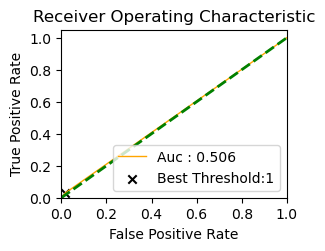

In [472]:
roc_auc(y_val_pred, y_val)

### Decision Tree

In [392]:
%%time

model = DecisionTreeClassifier()

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('rus', RandomUnderSampler(random_state=13)),
    ('model', model)    
])

param_grid = {
    'model__random_state': [13],
    'model__max_depth': [5,10,15,20],
    'model__min_samples_split': [2,3,4,5]
}
dt_search = GridSearchCV(pipe, param_grid=param_grid, cv = 5, verbose = True, n_jobs = -1, scoring='f1_macro')
dt_search.fit(X_train, y_train)

print(f'best parameters:', dt_search.best_params_)
dt_search.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
best parameters: {'model__max_depth': 10, 'model__min_samples_split': 3, 'model__random_state': 13}
Wall time: 1min 51s


0.5289184033094271

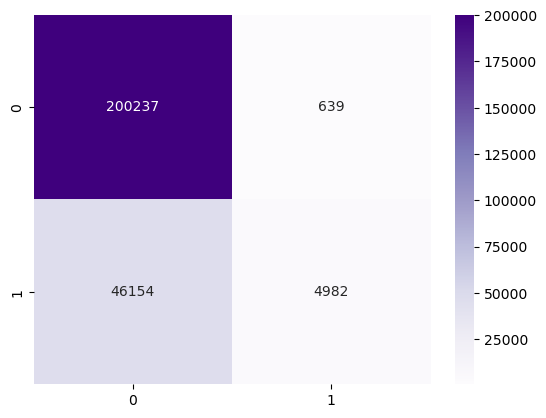

              precision    recall  f1-score   support

           0       0.81      1.00      0.90    200876
           1       0.89      0.10      0.18     51136

    accuracy                           0.81    252012
   macro avg       0.85      0.55      0.54    252012
weighted avg       0.83      0.81      0.75    252012



In [529]:
dt = dt_search.best_estimator_

dt.fit(X_train,y_train)

y_val_pred = dt.predict(X_val)


reports(y_val_pred, y_val)

Area under curve :  0.5471227018306875 



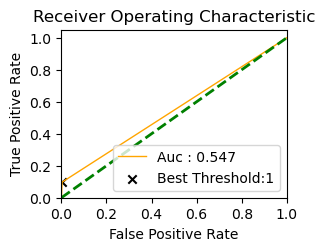

In [474]:
roc_auc(y_val_pred, y_val)

### XGBoost

In [394]:
%%time

model = XGBClassifier()

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('rus', RandomUnderSampler(random_state=13)),
    ('model', model)    
])

param_grid = {
    'model__random_state': [13],
    'model__max_depth': [5,10,15,20],
    'model__n_estimators': [40,140,240,340],
    'model__eta': [.05,.1,.2]
}

xgb_search = GridSearchCV(pipe, param_grid=param_grid, cv = 5, verbose = True, n_jobs = -1, scoring='f1_macro')
xgb_search.fit(X_train, y_train)

print(f'best parameters:', xgb_search.best_params_)
xgb_search.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best parameters: {'model__eta': 0.2, 'model__max_depth': 5, 'model__n_estimators': 340, 'model__random_state': 13}
Wall time: 53min 7s


0.5729772010981871

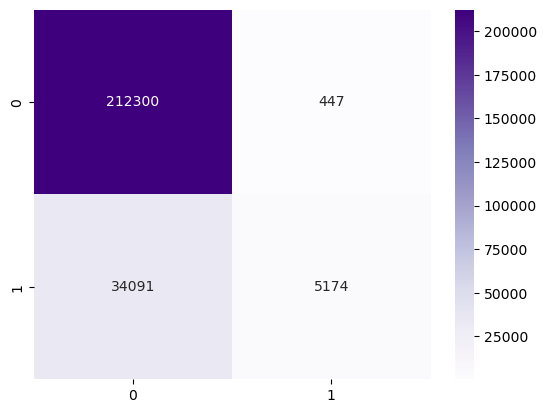

              precision    recall  f1-score   support

           0       0.86      1.00      0.92    212747
           1       0.92      0.13      0.23     39265

    accuracy                           0.86    252012
   macro avg       0.89      0.56      0.58    252012
weighted avg       0.87      0.86      0.82    252012



In [530]:
xgb = xgb_search.best_estimator_

xgb.fit(X_train,y_train)

y_val_pred = xgb.predict(X_val)

reports(y_val_pred, y_val)

Area under curve :  0.5648351051932032 



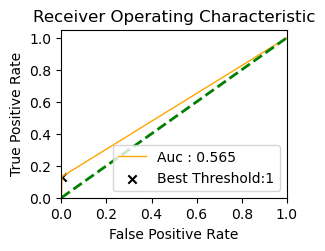

In [476]:
roc_auc(y_val_pred, y_val)

### LightGBM

In [548]:
%%time

model = lgb.LGBMClassifier()

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('rus', RandomUnderSampler(random_state=13)),
    ('model', model)    
])

param_grid = {
    'model__random_state': [13],
    'model__max_depth': [5,10,15,20],
    'model__n_estimators': [40,140,240,340],
    'model__learning_rate': [0.5,.1,.2]
    }

lgb_search = GridSearchCV(pipe, param_grid=param_grid, cv = 5, verbose = True, n_jobs = -1, scoring='f1_macro')
lgb_search.fit(X_train, y_train)

print(f'best parameters:', lgb_search.best_params_)
lgb_search.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 340, 'model__random_state': 13}
Wall time: 13min 40s


0.5724775901723136

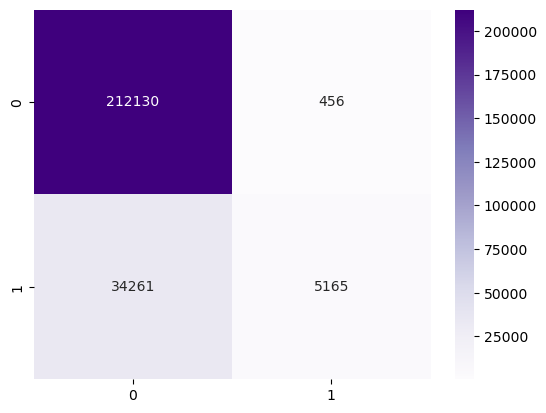

              precision    recall  f1-score   support

           0       0.86      1.00      0.92    212586
           1       0.92      0.13      0.23     39426

    accuracy                           0.86    252012
   macro avg       0.89      0.56      0.58    252012
weighted avg       0.87      0.86      0.82    252012



In [573]:
lgb_model = lgb_search.best_estimator_

lgb_model.fit(X_train,y_train)

y_val_pred = lgb_model.predict(X_val)

reports(y_val_pred, y_val)

Area under curve :  0.564150847347446 



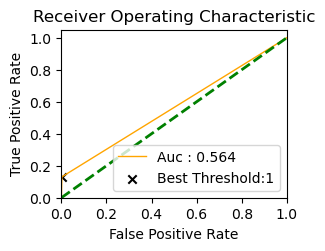

In [507]:
roc_auc(y_val_pred, y_val)

#### Note

- Both XGBoost and LGBM models showed similar results and provided 'better' f1 score and AUC, however none of the models were able to improve dramatically with hyperparameter tuning

## Stacking 

Previously fitted model with the best parameters were stacked to check if they would improve the overall performance.

Unfortunately, there was not improvement observed neither in f1 scoring, nor the AUC. The model is unable to effectively differentiate between the classes, no matter which final estimator was used

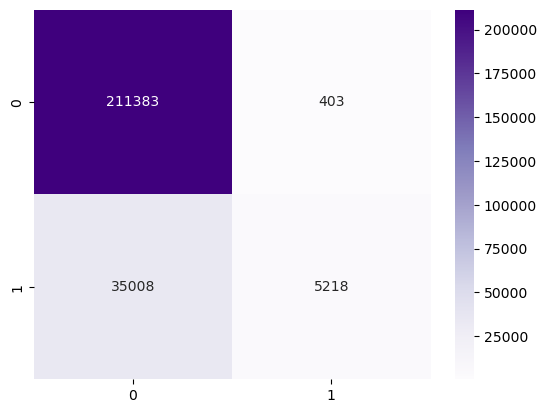

              precision    recall  f1-score   support

           0       0.86      1.00      0.92    211786
           1       0.93      0.13      0.23     40226

    accuracy                           0.86    252012
   macro avg       0.89      0.56      0.58    252012
weighted avg       0.87      0.86      0.81    252012

Wall time: 5min 7s


In [551]:
%%time

estimators = [
    ('lr',  lr.named_steps['model']),
    ('dt',  dt.named_steps['model']),
    ('lgb', lgb_model.named_steps['model']),
    ('xgb', xgb.named_steps['model'])
      
]
stacked_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('rus', RandomUnderSampler(random_state=13)),
    ('clf', StackingClassifier(estimators=estimators, final_estimator=lgb.LGBMClassifier()))    
])

stacked_pipe.fit(X_train, y_train)

y_pred_val = stacked_pipe.predict(X_val)

reports(y_pred_val, y_val)


Area under curve :  0.5644299531788546 



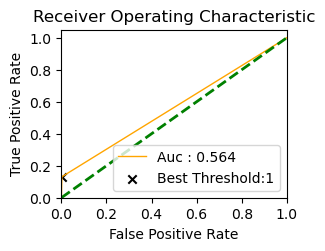

In [552]:
roc_auc(y_val_pred, y_val)

### Neural Network
- Will be using MLP Sequential for this project
- I was unable to use my preprocessing pipeline for this task, so manual column transformations were performed before trying the model

In [631]:
columns_to_encode = ['user_id', 'product_id', 'aisle_id', 'department_id']

# Frequency Encoding X_train features
X_try_train = X_train.copy()
X_try_train = frequency_encode_columns(X_try_train, columns_to_encode)

# Frequency Encoding X_val features
X_try_val = X_val.copy()
X_try_val = frequency_encode_columns(X_try_val, columns_to_encode)

# Frequency Encoding X_train_full features
X_try_train_full = X_train_full.copy()
X_try_train_full = frequency_encode_columns(X_try_train_full, columns_to_encode)

# Frequency Encoding X_test features
X_try_test = X_test.copy()
X_try_test = frequency_encode_columns(X_try_test, columns_to_encode)

In [632]:
# One-hot encoding 
X_train_trans = pd.get_dummies(X_try_train, drop_first=True)
X_train_full_trans = pd.get_dummies(X_try_train_full, drop_first=True)
X_val_trans = pd.get_dummies(X_try_val, drop_first=True)
X_test_trans = pd.get_dummies(X_try_test, drop_first=True)

In [633]:
# Scaling
scaler = MinMaxScaler()
rus = RandomUnderSampler(random_state=13)

X_train_scaled = scaler.fit_transform(X_train_trans)
X_train_full_scaled = scaler.fit_transform(X_train_full_trans)
X_val_scaled = scaler.fit_transform(X_val_trans)
X_test_scaled = scaler.fit_transform(X_test_trans)

# Undersampling
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_full_scaled, y_train_full)

### Model Training and validation

In [747]:
np.random.seed(13)
tf.random.set_seed(13)

mlp = Sequential()

mlp.add(InputLayer(input_shape=(76, )))
mlp.add(Dense(300, activation='relu'))
mlp.add(Dense(150, activation='relu'))

mlp.add(Dense(1, activation='sigmoid'))

In [748]:
mlp.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 300)               23100     
                                                                 
 dense_78 (Dense)            (None, 150)               45150     
                                                                 
 dense_79 (Dense)            (None, 1)                 151       
                                                                 
Total params: 68,401
Trainable params: 68,401
Non-trainable params: 0
_________________________________________________________________


In [749]:
mlp.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[get_f1])

In [750]:
%%time 
history = mlp.fit(X_resampled, y_resampled, epochs=10, validation_data=(X_val_scaled, y_val)) 

Epoch 1/10
1054/1054 [==============================] - 23s 21ms/step - loss: 0.5773 - get_f1: 0.7650 - val_loss: 0.4771 - val_get_f1: 0.1226
Epoch 2/10
1054/1054 [==============================] - 21s 20ms/step - loss: 0.4451 - get_f1: 0.7976 - val_loss: 0.4344 - val_get_f1: 0.1257
Epoch 3/10
1054/1054 [==============================] - 22s 21ms/step - loss: 0.4267 - get_f1: 0.8023 - val_loss: 0.4379 - val_get_f1: 0.1257
Epoch 4/10
1054/1054 [==============================] - 23s 22ms/step - loss: 0.4184 - get_f1: 0.8054 - val_loss: 0.4518 - val_get_f1: 0.1239
Epoch 5/10
1054/1054 [==============================] - 23s 22ms/step - loss: 0.4113 - get_f1: 0.8096 - val_loss: 0.4457 - val_get_f1: 0.1242
Epoch 6/10
1054/1054 [==============================] - 23s 22ms/step - loss: 0.4045 - get_f1: 0.8114 - val_loss: 0.3828 - val_get_f1: 0.1328
Epoch 7/10
1054/1054 [==============================] - 24s 22ms/step - loss: 0.3974 - get_f1: 0.8139 - val_loss: 0.4090 - val_get_f1: 0.1302
Epoch 

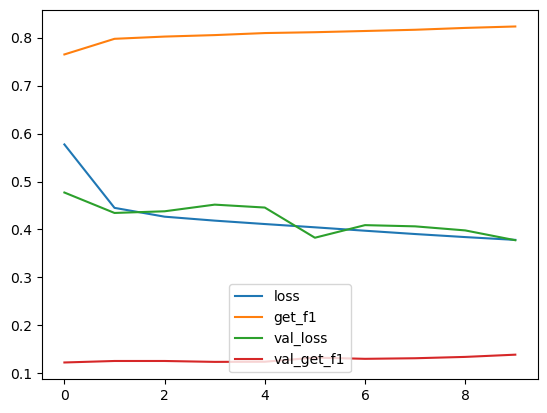

In [751]:
pd.DataFrame(history.history).plot();

7876/7876 [==============================] - 18s 2ms/step


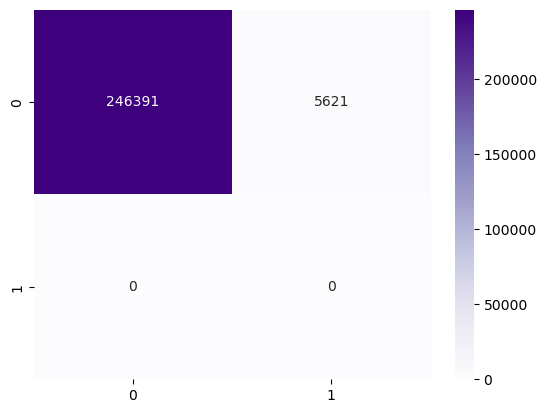

D:\Users\Opekh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Opekh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    252012
           1       0.00      0.00      0.00         0

    accuracy                           0.98    252012
   macro avg       0.50      0.49      0.49    252012
weighted avg       1.00      0.98      0.99    252012



D:\Users\Opekh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [752]:
y_val_pred = mlp.predict(X_val_scaled)

y_pred = np.argmax(y_val_pred, axis=1)

reports(y_pred, y_val)

In [746]:
y_val_pred

array([[0.80509883],
       [0.21739328],
       [0.11961147],
       ...,
       [0.25602943],
       [0.24344565],
       [0.0816109 ]], dtype=float32)

Area under curve :  0.5438380085964426 



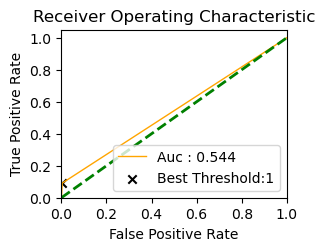

In [610]:
roc_auc(y_pred, y_val)

### Final Prediction

There were no notieceable differences between our validation model performance and final model performance for both stacked and keras.

This brings us to the conclusion that at its current state, neither model performs well and needs further improvements.

### Stacked Model

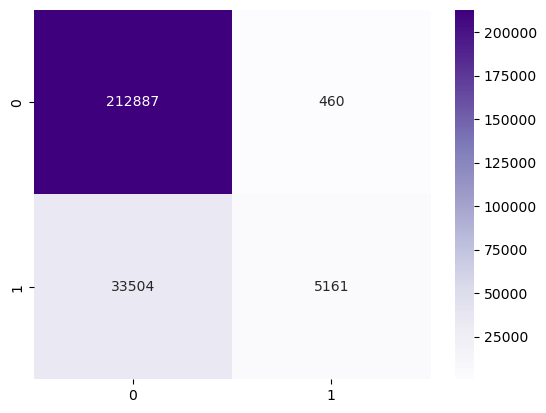

              precision    recall  f1-score   support

           0       0.86      1.00      0.93    213347
           1       0.92      0.13      0.23     38665

    accuracy                           0.87    252012
   macro avg       0.89      0.57      0.58    252012
weighted avg       0.87      0.87      0.82    252012

Wall time: 3min 4s


In [648]:
%%time

estimators = [
#     ('lr',  lr.named_steps['model']),
#     ('dt',  dt.named_steps['model']),
    ('lgb', lgb_model.named_steps['model']),
    ('xgb', xgb.named_steps['model'])
      
]
stacked_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('rus', RandomUnderSampler(random_state=13)),
    ('clf', StackingClassifier(estimators=estimators, final_estimator=lgb.LGBMClassifier()))    
])

stacked_pipe.fit(X_train_full, y_train_full)

y_pred = stacked_pipe.predict(X_test)

reports(y_pred, y_test)

Area under curve :  0.5656618897502725 



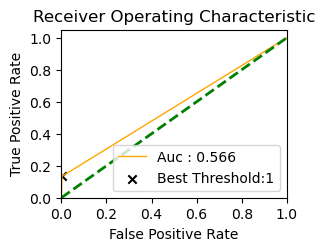

In [649]:
roc_auc(y_pred, y_test)

### Neural Networks

In [641]:
%%time 
history = mlp.fit(X_train_resampled, y_train_resampled, epochs=20, validation_data=(X_test_scaled, y_test)) 

Epoch 1/20
1406/1406 [==============================] - 27s 19ms/step - loss: 0.5190 - get_f1: 0.4472 - val_loss: 0.4803 - val_get_f1: 0.0408
Epoch 2/20
1406/1406 [==============================] - 26s 18ms/step - loss: 0.4304 - get_f1: 0.5824 - val_loss: 0.4354 - val_get_f1: 0.0398
Epoch 3/20
1406/1406 [==============================] - 25s 18ms/step - loss: 0.4174 - get_f1: 0.5838 - val_loss: 0.4329 - val_get_f1: 0.0403
Epoch 4/20
1406/1406 [==============================] - 24s 17ms/step - loss: 0.4064 - get_f1: 0.5838 - val_loss: 0.4027 - val_get_f1: 0.0392
Epoch 5/20
1406/1406 [==============================] - 25s 18ms/step - loss: 0.3947 - get_f1: 0.5848 - val_loss: 0.4265 - val_get_f1: 0.0408
Epoch 6/20
1406/1406 [==============================] - 24s 17ms/step - loss: 0.3829 - get_f1: 0.5861 - val_loss: 0.3569 - val_get_f1: 0.0378
Epoch 7/20
1406/1406 [==============================] - 25s 18ms/step - loss: 0.3727 - get_f1: 0.5885 - val_loss: 0.3924 - val_get_f1: 0.0400
Epoch 

7876/7876 [==============================] - 20s 3ms/step


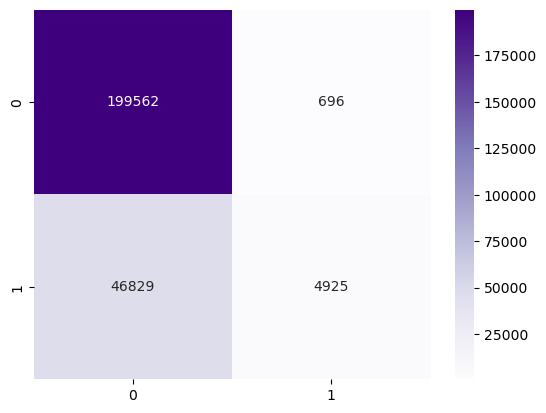

              precision    recall  f1-score   support

           0       0.81      1.00      0.89    200258
           1       0.88      0.10      0.17     51754

    accuracy                           0.81    252012
   macro avg       0.84      0.55      0.53    252012
weighted avg       0.82      0.81      0.75    252012



In [646]:
y_pred = mlp.predict(X_test_scaled)

y_pred = np.argmax(y_pred, axis=1)

reports(y_pred, y_test)

Area under curve :  0.5458431050231093 



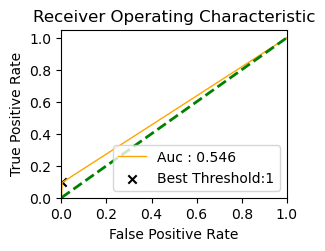

In [647]:
roc_auc(y_pred, y_test)

### Model Interpretation

At this time, I was not able to extract any meaningful information about the stacked model due to it being such a complex instance to either get the feature importances or LIME

I will be using LIME to interpret some false positives and false negatives in the the Sequential model

### Keras Model


#### Checking the product that the model predicted to have been bought but was actually not

In [659]:
explainer = LimeTabularExplainer(X_test_trans.values, feature_names=X_test_trans.columns.values, class_names=['not_ordered', 'ordered'])

D:\Users\Opekh\anaconda3\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


In [652]:
label = pd.DataFrame(y_test)

In [651]:
y_proba = mlp.predict(X_test_scaled)[:, 1]

7876/7876 [==============================] - 23s 3ms/step


In [701]:
result = X_test.copy()

result['probability'] = y_proba

table = pd.merge(result, label, how='left', left_index=True, right_index=True)

sorted_table = table.sort_values(by='probability', ascending=False)

sorted_table[sorted_table['ordered']==0]

user_id  order_number order_dow order_hour_of_day  \
565269    114468            32         3                12   
1003167   197361             8         6                16   
597677    160615            21         3                15   
512743    138426             4         2                11   
641151    201779            77         2                20   
...          ...           ...       ...               ...   
173866     12873            23         6                21   
458665      5745            38         0                18   
575831    100634            45         1                 9   
1213741   117209            14         6                 9   
1010901   173951            52         6                14   

         days_since_prior_order  order_size product_id aisle_id department_id  \
565269                     23.0          21      13176     24.0           4.0   
1003167                    30.0          17       1962     91.0          16.0   
597677                     30.0          21       7332     43.0           3.0   
512743                     17.0          22      13176     24.0           4.0   
641151                     13.0          20      13176     24.0           4.0   
...                         ...         ...        ...      ...           ...   
173866                     10.0          29      21136    109.0          11.0   
458665                      6.0          23      48672    132.0          11.0   
575831                      4.0          21      29984     26.0           7.0   
1213741                    11.0          16      35520    104.0          13.0   
1010901                     7.0          17      25888     47.0          11.0   

         is_healthy  ...  prior_freq_dow  prior_freq_hour  \
565269          1.0  ...               4               14   
1003167         0.0  ...               3               16   
597677          0.0  ...               0               19   
512743          1.0  ...               6               18   
641151          1.0  ...               3               19   
...             ...  ...             ...              ...   
173866          0.0  ...               5               21   
458665          0.0  ...               1               18   
575831          0.0  ...               3               17   
1213741         0.0  ...               0                4   
1010901         0.0  ...               5               21   

         product_reorder_ratio  dept_reorder_ratio aisle_reorder_ratio  \
565269                0.875000            0.620605            0.846191   
1003167               0.799805            0.444336            0.538574   
597677                0.799805            0.823730            0.866699   
512743                0.666504            0.378418            0.416748   
641151                0.956543            0.788086            0.863770   
...                        ...                 ...                 ...   
173866                0.500000            0.181763            0.000000   
458665                0.666504            0.000000            0.000000   
575831                0.500000            0.000000            0.000000   
1213741               0.000000            0.000000            0.000000   
1010901               0.909180            0.000000            0.000000   

        prod_reorder_frequency  aisle_reorder_frequency  \
565269                    14.0                     14.0   
1003167                   15.0                     17.0   
597677                    17.0                     16.0   
512743                    16.0                     18.0   
641151                     6.0                      5.0   
...                        ...                      ...   
173866                    10.0                      0.0   
458665                    10.0                      0.0   
575831                     6.0                      0.0   
1213741                    0.0                      0.0   
1010901             

In [753]:
row = 621766
exp = explainer.explain_instance(X_test_trans.loc[row], mlp.predict, num_features=8, top_labels=1)
exp.show_in_notebook()

157/157 [==============================] - 0s 2ms/step


D:\Users\Opekh\anaconda3\lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


- It looks like aisle_reorder_ratio played a large part in determining whether the product was bought or not
- Product reorder ratio and order hour were the only features that indicated no order

#### Checking the product that the model predicted to not have been bought but was actually ordered

In [717]:
sorted_table = table.sort_values(by='probability')

sorted_table[sorted_table['ordered']==1]

user_id  order_number order_dow order_hour_of_day  \
1017598   101975            26         0                15   
617143    164319            12         4                16   
783089    141077            45         6                17   
500325    102776            29         0                 8   
184887     15503            39         0                12   
...          ...           ...       ...               ...   
313462    125550            27         5                14   
1254850   120119            14         1                14   
646017    176714            15         0                15   
849061    169195            41         5                 7   
262433    155880            52         2                11   

         days_since_prior_order  order_size product_id aisle_id department_id  \
1017598                    12.0          17      32368      4.0           9.0   
617143                     30.0          20       6128     78.0          19.0   
783089                     10.0          19       6568     50.0          19.0   
500325                      7.0          22      20608     19.0          13.0   
184887                      4.0          28       6128     78.0          19.0   
...                         ...         ...        ...      ...           ...   
313462                      8.0          25      13176     24.0           4.0   
1254850                     7.0          16      13176     24.0           4.0   
646017                     14.0          20      13176     24.0           4.0   
849061                      3.0          18      13176     24.0           4.0   
262433                      5.0          26      13176     24.0           4.0   

         is_healthy  ...  prior_freq_dow  prior_freq_hour  \
1017598         0.0  ...               2               12   
617143          0.0  ...               3               17   
783089          0.0  ...               3               14   
500325          0.0  ...               0               12   
184887          0.0  ...               3                7   
...             ...  ...             ...              ...   
313462          1.0  ...               6               12   
1254850         1.0  ...               1               15   
646017          1.0  ...               0               16   
849061          1.0  ...               5               15   
262433          1.0  ...               6               14   

         product_reorder_ratio  dept_reorder_ratio aisle_reorder_ratio  \
1017598               0.000000            0.545410            0.523926   
617143                0.000000            0.150024            0.000000   
783089                0.000000            0.620605            0.000000   
500325                0.000000            0.219482            0.142822   
184887                0.000000            0.562500            0.565430   
...                        ...                 ...                 ...   
313462                0.916504            0.615234            0.755859   
1254850               0.909180            0.696777            0.782715   
646017                0.916504            0.709473            0.767578   
849061                0.941406            0.821777            0.862793   
262433                0.944336            0.824707            0.856934   

        prod_reorder_frequency  aisle_reorder_frequency  \
1017598                   30.0                      9.0   
617143                    21.0                     12.0   
783089                     4.0                      9.0   
500325                     8.0                      7.0   
184887                     9.0                      8.0   
...                        ...                      ...   
313462                    10.0                     11.0   
1254850                    7.0                      9.0   
646017                    15.0                     15.0   
849061                     6.0                      5.0   
262433              

In [718]:
row = 1017598
exp = explainer.explain_instance(X_test_trans.loc[row], mlp.predict, num_features=8, top_labels=1)
exp.show_in_notebook()

157/157 [==============================] - 1s 6ms/step


D:\Users\Opekh\anaconda3\lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


Here, we again observe the impact of aisle reorder column, this time joined by aisle reorder frequency which tipped this one over to the side of not ordered

Product reorder ratio was also a strong player in this decision, making me believe that without additional feature it may not be a good standalone feature as it may encourage strong swings in the wrong direction.

# Conclusions
Overall, there is definitely room for improvement. The models did not end up performing as well as I was hoping and the scores were way below the average of 0.35 fro f1 score. The ROC AUC is also lackluster. 


Some things that can improve the model performance:
- adding more/better features will definitely help
- trying different types of encoders
- trying other ML algorithms that people have used: RandomForest, Catboost
- Try a wider scope in terms of hyperparameter tuning, trying wider range od parameters and re-running the SearchGrid to optimize

Things to try:

- In the Market Basket Analysis, apriori algorith is often use to perform association rules search. This can create itemsets that are often bought together and is considered to be a great tool to create recommendations 
- For this project and with the way the prediction systems were set, I was unable to fit Apriori, but it is definitely something to explore

# End of Notebook